In [2]:
import os
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn 

import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, CrossEntropyLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
# torch.set_default_device('cuda')

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


from utils import MultiClassImageDataset, Base_Model, preprocessing, CreateQNN,ResNet50_Model,ProgressBar,OrthoModel_Binary_ClQ
from utils import *
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
IMAGE_SIZE = 64
BATCH_SIZE = 256
NUM_QUBIT = 4
TEST_DATA_NUMBER= 1000
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_"
root_dir_binary = "/home/aws_install/projects/QCML/QNN4EO/Dataset/Small_Train/"
root_dir_binary_test = "/home/aws_install/projects/QCML/QNN4EO/Dataset/Small_Test/"
backup_acc_data = None

Test Image torch.Size([1, 3, 64, 64])
Test Label tensor([2])




 {0: Parameter(X0), 1: Parameter(X1), 2: Parameter(X2), 3: Parameter(X3)}
6.0 3.0
6.0 3.0 {0: Parameter(T_L10), 1: Parameter(T_L11), 2: Parameter(T_L12)}
OrthoModel_Binary_ClQ(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout4): Dropout2d(p=0.5, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=2, strid

KeyboardInterrupt: 

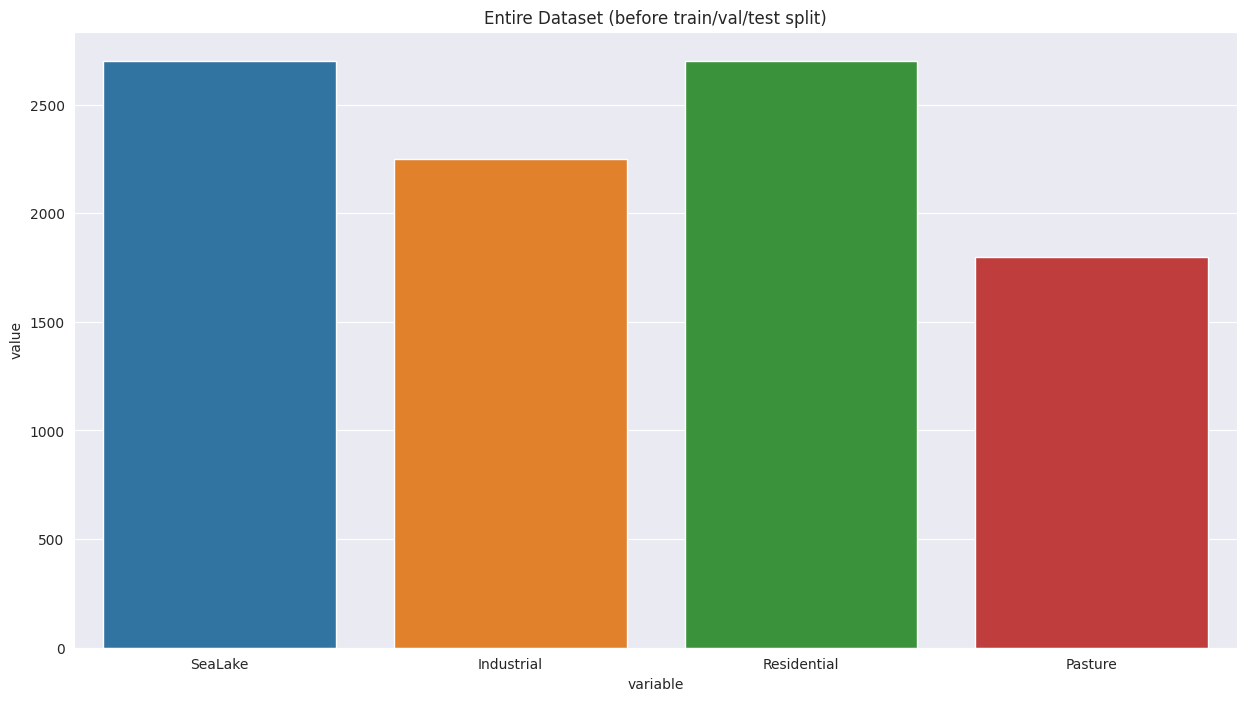

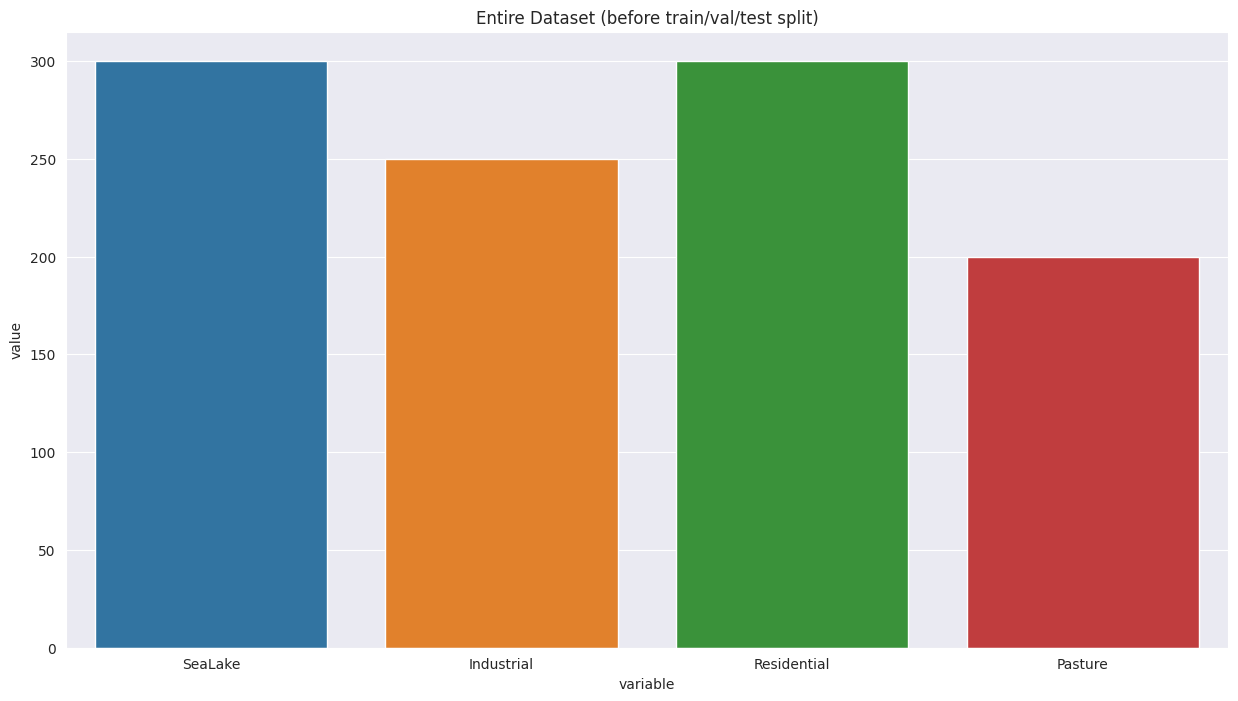

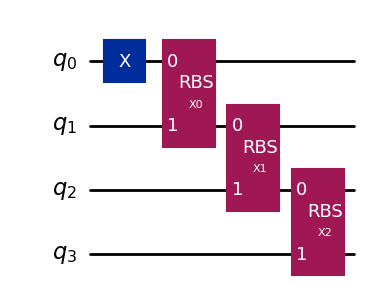

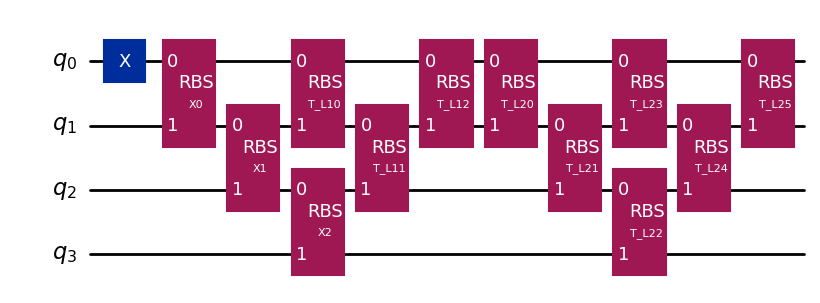

In [51]:

def process_target_1Hot(target):
    target = F.one_hot(target, num_classes=4)
    target =  target.to(torch.float32)
    return target


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
d = next(iter(test_loader))
print("Test Image" , d[0].shape)
print("Test Label" , d[1])

# QC_NN = CreateQNN(NUM_QUBIT)
QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
# multiClassBaseModel = Base_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel = ResNet50_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel.eval()
# multiClassResnetModel.resnet_encoder.eval()

# multiClassBaseModel.eval()  # Set model to training mode


classifierModel = Binary_classifier_classical
print(classifierModel)
MSEL = True

# optimizer = optim.Adam(classifierModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()
if MSEL:
    loss_func = MSELoss()

# Start training
loss_list = []  # Store loss history
total_loss= []
accuracy=[]
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_239.pt"
Binary_classifier_classical.Train_Classical = True
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_c"+str(50)+".pt"
Binary_classifier_classical.Train_Classical = False
classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()

print(classifierModel)

images =[]
label = []
preds = []
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == TEST_DATA_NUMBER:
        break
    target= target.to(device)
    data= data.to(device)
    output = classifierModel(data)  # Forward pass
    # test both parts 
    o = classifierModel.classical_encoder(data) 
    norm = torch.norm(o, dim=1, keepdim=True)
        # Normalize each data point in the batch
    o = o / (norm+1e-8)
    o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
    o2 = classifierModel.quantum_part(o) 
    if MSEL:
        target_2 = process_target_1Hot(target)
        target_2= target_2.to(device)
        output =  F.sigmoid(10*output)

    loss = loss_func(output, target_2)  # Calculate loss
    preds.append(o2.cpu().detach().numpy())
    label.append(target.cpu().detach().numpy())
    images.append(data.cpu().detach().numpy())
    total_loss.append(loss.item())
    # print(str(np.int32(test_target == test_pred)))
    accuracy_test = np.int32(label[-1] == np.argmax(preds[-1]))
    accuracy.append(accuracy_test)

    # accuracy.append(np.argmax(pred[-1]))

loss_list.append(sum(total_loss) / len(total_loss))
print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
print("Testing \t accuracy: ", np.sum(accuracy)/len(accuracy))




In [47]:
acc_dd.append(0.5)
print(acc_dd)


[0.32, 0.32, 0.34, 0.497, 0.45, 0.31, 0.29, 0.26, 0.27, 0.33, 0.2, 0.25, 0.25, 0.39, 0.3, 0.32, 0.5]


Train Image torch.Size([256, 3, 64, 64])
Train Label tensor([0, 1, 1, 2, 1, 3, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 3, 2,
        2, 0, 1, 3, 3, 2, 2, 0, 3, 3, 2, 2, 1, 0, 0, 0, 3, 2, 1, 2, 0, 0, 3, 2,
        2, 0, 0, 0, 2, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0,
        3, 2, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 3, 3, 2, 0,
        0, 1, 2, 0, 3, 0, 3, 0, 0, 0, 1, 3, 1, 3, 3, 1, 3, 2, 2, 0, 2, 1, 0, 2,
        1, 0, 1, 1, 1, 0, 3, 2, 3, 2, 2, 1, 0, 3, 1, 1, 0, 3, 0, 3, 0, 1, 0, 1,
        3, 0, 1, 1, 0, 1, 3, 2, 3, 1, 3, 3, 0, 1, 2, 1, 1, 1, 2, 0, 3, 3, 0, 2,
        0, 0, 3, 1, 1, 3, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 3, 1, 1, 1, 2, 0,
        2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 3, 0, 2, 1, 3, 0, 2, 0, 3, 3, 3, 3, 0, 0,
        1, 2, 2, 3, 2, 2, 1, 0, 3, 3, 1, 1, 1, 2, 1, 3, 3, 0, 2, 0, 0, 2, 0, 1,
        0, 0, 2, 1, 0, 1, 3, 3, 2, 2, 0, 0, 3, 0, 3, 2])




 {0: Parameter(X0), 1: Parameter(X1), 2: Parameter(X2), 3: Parameter(X3)}
6.0 3.0
6.0 

KeyboardInterrupt: 

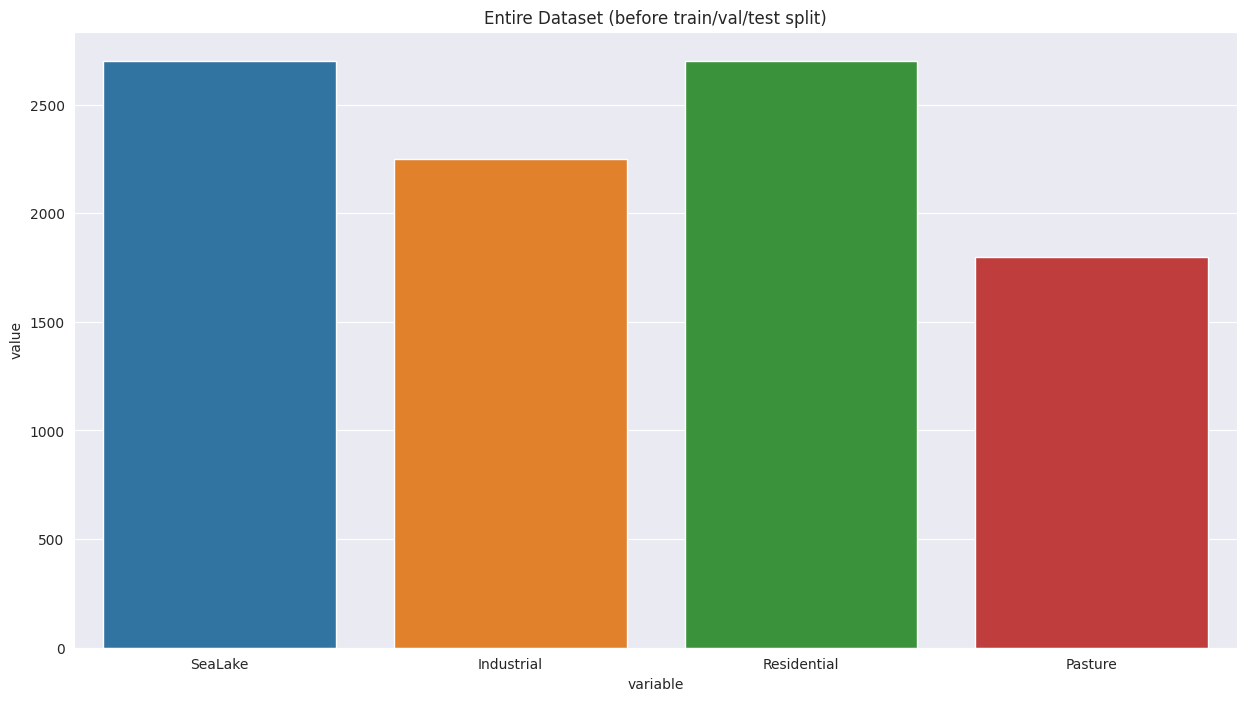

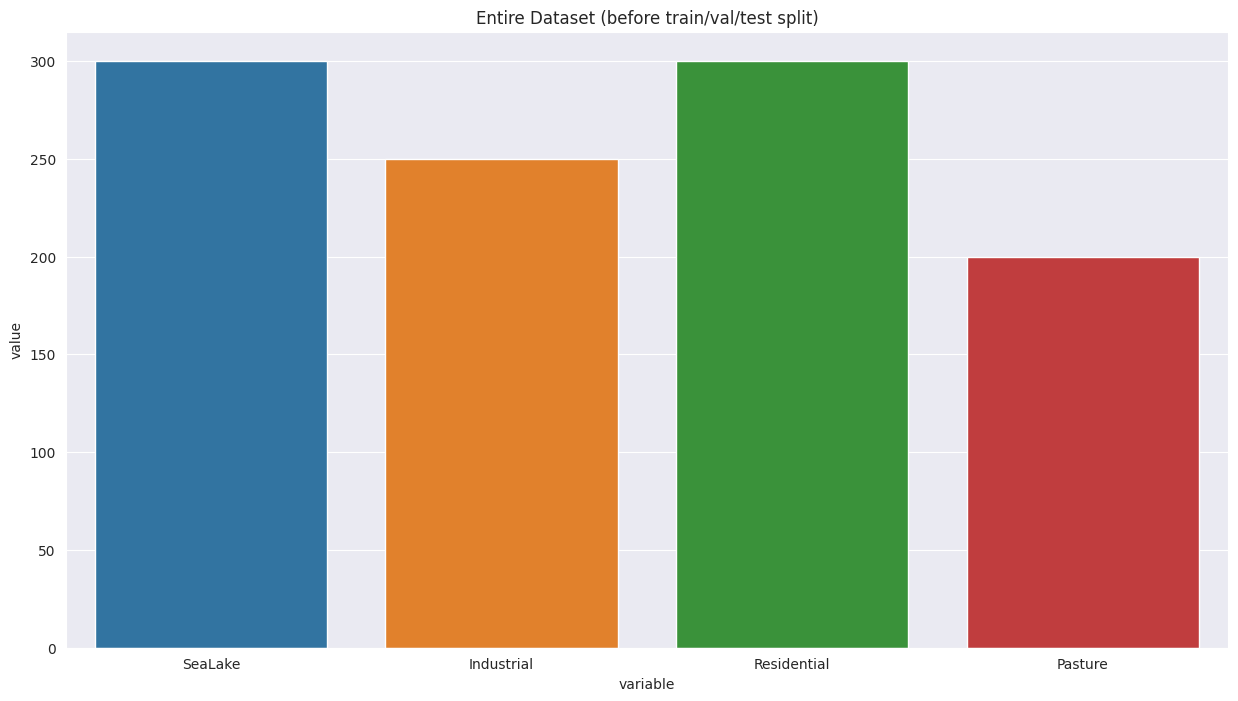

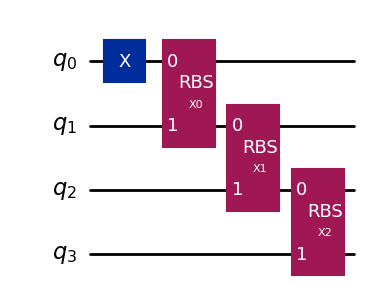

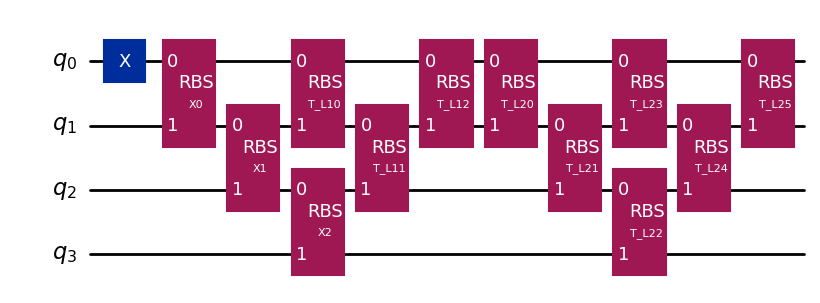

In [26]:
import random

TEST_DATA_NUMBER= 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
d = next(iter(train_loader))
print("Train Image" , d[0].shape)
print("Train Label" , d[1])

# QC_NN = CreateQNN(NUM_QUBIT)
# QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
# multiClassBaseModel = Base_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel = ResNet50_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel.eval()
# multiClassResnetModel.resnet_encoder.eval()

# multiClassBaseModel.eval()  # Set model to training mode


classifierModel = Binary_classifier_classical
print(classifierModel)


# optimizer = optim.Adam(classifierModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
loss_list = []  # Store loss history
total_loss= []
accuracy=[]
acc_data=[]
raw_data_pred =[]
raw_data_target =[]

loss_data= []
all_exp = [ "", "c", "cc", "ccc", "cccc"]
starti = [0, 0, 0, 0, 0]
endi = [120, 120, 120, 220, 200]


all_exp = ["", "c"]
starti = [0, 0, 0, 0, 0]
endi = [1, 1, 120, 220, 200]
# if backup_acc_data != None:
#     print("setting acc_data")
#     acc_data = backup_acc_data

all_exp_data = {}

for sd in [1000,1,3,1222,122,5,90,34,33]:

    random.seed(int(sd))
    test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
    acc_data = []
    loss_list = [] 
    
    for e, exp in enumerate(all_exp): 
        # if exp == "ccc":
        print(sd)
        #     end = 220
        start = starti[e]
        end = endi[e]
        for i in range(start, end, 1):    
            # SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_"+str(i)+".pt"
            # Binary_classifier_classical.Train_Classical = True
            SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_"+str(exp)+str(i)+".pt"
            # print("Model : ", SAVE_PATH )
            Binary_classifier_classical.Train_Classical = False
            classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
            classifierModel.eval()
            SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_3_"+str(exp)+str(i)+".pt"
            # print(classifierModel)

            images =[]
            label = []
            preds = []

            accuracy = [] 
            total_loss = []
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == TEST_DATA_NUMBER:
                    break
                target= target.to(device)
                data= data.to(device)
                output = classifierModel(data)  # Forward pass
                # test both parts 
                o = classifierModel.classical_encoder(data) 
                norm = torch.norm(o, dim=1, keepdim=True)
                    # Normalize each data point in the batch
                o = o / (norm+1e-8)
                o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
                o2 = classifierModel.quantum_part(o) 

                if Binary_classifier_classical.Train_Classical == False:
                    output=o2

                raw_data_pred.append(output.cpu().detach().numpy())
                raw_data_target.append(target.cpu().detach().numpy())

                loss = loss_func(output, target)  # Calculate loss
                
                preds.append(output.cpu().detach().numpy())
                label.append(target.cpu().detach().numpy())
                images.append(data.cpu().detach().numpy())
                total_loss.append(loss.item())
                predicted_labels = np.argmax(output.cpu().detach().numpy())
                target_labels = target.cpu().detach().numpy()
                # print(str(np.int32(test_target == test_pred)))
                accuracy_test = np.int32(target_labels == predicted_labels)
                accuracy.append(accuracy_test)

            

            # accuracy.append(np.argmax(pred[-1]))
            loss_list.append(sum(total_loss) / len(total_loss))
            acc_data.append(np.sum(accuracy)/len(accuracy))
            print("Testing ", SAVE_PATH, "Seed:", sd)
            print("\t\tTesting [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
            print("\t\tTesting \t accuracy: ", np.sum(accuracy)/len(accuracy))

        np.save(SAVE_PATH+"Acc_Data.npy", acc_data)
        np.save(SAVE_PATH+"Loss_Data.npy", loss_list)
        np.save(SAVE_PATH+"Raw_Data_Pred.npy", raw_data_pred)
        np.save(SAVE_PATH+"Raw_Data_Target.npy", raw_data_target)

        all_exp_data[sd] = [acc_data, loss_list]
        
        print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
        print("Testing \t accuracy: ", np.sum(accuracy)/len(accuracy))


In [5]:
exp = "23102024_4"
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical/Q_4_"+str(110)+".pt"
backup_acc_data = np.load(SAVE_PATH+exp+"Acc_Data10_10.npy")
backup_loss_data = np.load(SAVE_PATH+exp+"Loss_Data10_10.npy")
backup_pred_data = np.load(SAVE_PATH+exp+"Pred_data.npy")
backup_target_data = np.load(SAVE_PATH+exp+"Target.npy")
# backup_acc_data2 = backup_acc_data.extend(acc_data)

backup_acc_data2 = np.append(backup_acc_data, acc_data, 0)
backup_loss_data2 = np.append(backup_loss_data, loss_data, 0)
backup_pred_data2 = np.append(backup_pred_data, raw_data_pred, 0)
backup_target_data2 = np.append(backup_target_data, raw_data_target, 0)

# backup_loss_data2 = backup_loss_data.extend(loss_data)
# backup_pred_data2 = backup_pred_data.extend(raw_data_pred)
# backup_target_data2 = backup_target_data.extend(raw_data_target)

FileNotFoundError: [Errno 2] No such file or directory: '/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical/Q_4_110.pt23102024_4Acc_Data10_10.npy'

In [28]:
all_exp_data[1]

[[0.02, 0.33], [1.3055945885181428, 1.0901578712463378]]

In [6]:
exp = "23102024_4"
backup_acc_data = acc_data
np.save(SAVE_PATH+exp+"Acc_Data10_10.npy", acc_data)
backup_loss_data  = loss_data
np.save(SAVE_PATH+exp+"Loss_Data10_10.npy", loss_data)
backup_pred_data  = raw_data_pred
backup_target_data  = raw_data_target
np.save(SAVE_PATH+exp+"Pred_data.npy", backup_pred_data)
np.save(SAVE_PATH+exp+"Target.npy", backup_target_data)
print( np.shape(backup_target_data))

(78000, 1)


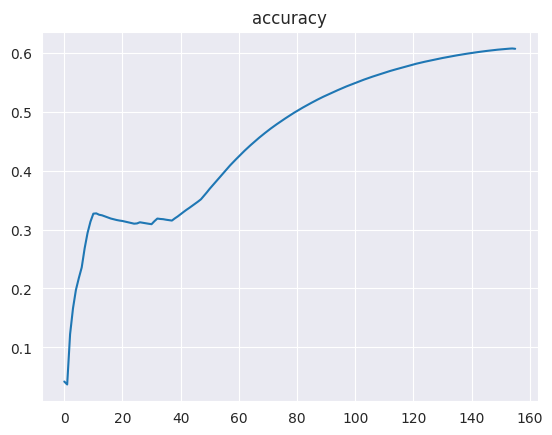

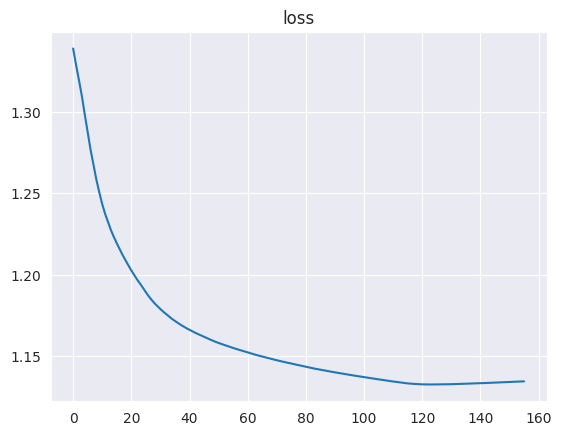

In [5]:
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical/Q_4_"+str(i)+".pt"
exp = "23102024_4"
plt.figure("Accuracy vs Epochs") # Here's the part I need
plt.title('accuracy')
plt.plot(acc_data )
plt.savefig(SAVE_PATH+ "_accuracy_valQ4_"+exp+".png")

plt.figure("Loss vs Epoch") 
plt.title('loss')
plt.plot(loss_list)
plt.savefig(SAVE_PATH+ "_loss_valQ4"+exp+".png")

In [ ]:
print(acc_data, loss_data)

In [ ]:
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical/Q_4_"+str(i)+".pt"
exp = "14102024_4"
plt.figure("Accuracy vs Epochs") # Here's the part I need
plt.title('accuracy')
plt.plot(acc_data, )
plt.savefig(SAVE_PATH+ "_accuracy_valQ4_"+exp+".png")

plt.figure("Loss vs Epoch") 
plt.title('loss')
plt.plot(loss_list)
plt.savefig(SAVE_PATH+ "_loss_valQ4"+exp+".png")


In [ ]:
import matplotlib.ticker as ticker

x = 4
y = -10
x2 = 40
y2= -10
# fig, ax = plt.subplots(figsize=(10, 6))
# fig, axs = plt.subplots(8, 2, figsize=(10, 6))
fig, axs = plt.subplots(ncols=5,nrows=1)
plt.xticks([]) 
plt.yticks([]) 
print(axs)
for i, ax in enumerate(axs.ravel()):
    print(i)
    img = images[i][0,:,:,:].transpose((1,2,0))
    lab = int(label[i])
    pred = np.argmax(preds[i])
    # axs[i] = plt.gca()
    s = "T:"+ str(dataSet.class_folders[lab][0])
    s2 =  "P:"+ str(dataSet.class_folders[pred][0]) #str(pred)
    axs[i].set_axis_off()
    axs[i].imshow(img)
    axs[i].text(x, y, s, bbox=dict(fill=False, edgecolor='green', linewidth=2), c= "black")
    axs[i].text(x2, y2, s2, bbox=dict(fill=False, edgecolor='red', linewidth=2), c= "black")

In [ ]:
dataSet.class_folders

In [41]:
from sklearn import metrics
pred_labels = np.array(preds)[:,0,:].argmax(axis=1)
pred_labels2 = np.array(arr_pp)
target_labels = np.array(label)[:,0]
print(target_labels.shape, pred_labels.shape)

confusion_matrix = metrics.confusion_matrix(target_labels, pred_labels)
confusion_matrix2 = metrics.confusion_matrix(target_labels, pred_labels2)

(14450,) (14450,)


In [38]:
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in dataSet.class_folders],
                  columns = [i for i in dataSet.class_folders])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

ValueError: Shape of passed values is (6, 6), indices imply (4, 4)

<Axes: >

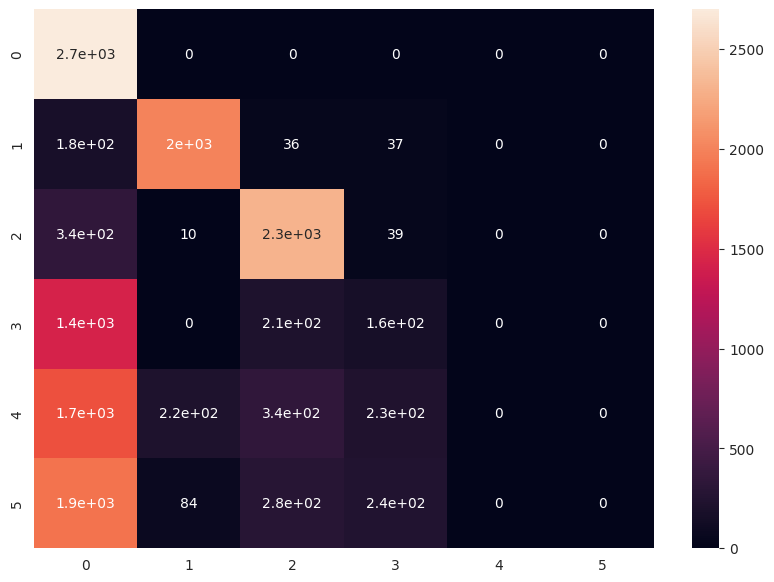

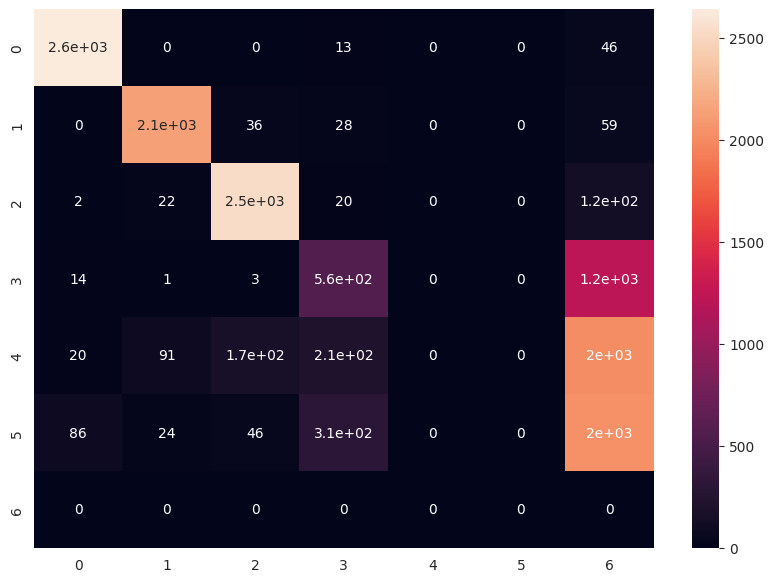

In [44]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=True)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix2, annot=True)

In [ ]:
o, o2, preds[-1], output, label[-1]



In [ ]:
o2

In [ ]:
np.argmax(preds[-1])
label[-1]


In [ ]:
classifierModel.Train_Classical

# Test Quantum circuit .... 


In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn 

import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, CrossEntropyLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    MSELoss,
)
import torch.nn.functional as F
# torch.set_default_device('cuda')

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


from utils import MultiClassImageDataset, Base_Model, preprocessing, \
    CreateQNN,ResNet50_Model, ProgressBar, ResNet50_Model_Binary, \
        ResNet50_OrthoModel_Binary, ResNet50_OrthoModel_Binary_ClQ
    
from utils import CreateQNN_Ex, CreateOrthogonalQNN, CreateOrthogonalQNN4

In [ ]:
QC_NN = CreateOrthogonalQNN4(4)

In [ ]:
QC_NN

In [ ]:
from utils import *
import matplotlib.pyplot as plt

%matplotlib inline

def RBS_Pyramid_Trainable_local_test(NUM_QUBITS = 4):


    # thetas = {k : Parameter('T_L1'+str(k))for k in range(3)}

    num_param = NUM_QUBITS * (NUM_QUBITS-1) / 2  - (NUM_QUBITS-1)
    num_param2 = (NUM_QUBITS * (NUM_QUBITS-1) / 2)

    print(num_param2, num_param )
    thetas = {k : Parameter('T_L1'+str(k))for k in range(int(num_param))}
    thetas_layer2 = {k : Parameter('T_L2'+str(k))for k in range(int(num_param2))}
    print(num_param2, num_param , thetas )

    ansatz = qiskit.QuantumCircuit(NUM_QUBITS)    

    # layer 1 without data loaders
    k = 0
    for i in range(NUM_QUBITS-2):
        for j in range (NUM_QUBITS-2-i):
            ansatz.append(RBS(thetas[k]), [j, j+1])
            k+=1
    
    # layer 2 full v
    k = 0
    for i in range(NUM_QUBITS-1):
        for j in range (NUM_QUBITS-1-i):
            ansatz.append(RBS(thetas_layer2[k]), [j, j+1])
            k+=1
    
    # for i in range(3):
    #     ansatz.append(RBS(thetas_layer2[i]), [i, i+1])
    # for i in range(2):
    #     ansatz.append(RBS(thetas_layer2[i]), [i, i+1])
    
    # ansatz.append(RBS(thetas_layer2[2]), [0, 1])
   

    return ansatz



def CreateOrthogonalQNN4_local_test(num_qubits = 4): 
    from qiskit.circuit import Parameter
    input_parameters  = {k : Parameter('X'+str(k))for k in range(num_qubits)}
    thetas = {k : Parameter('Theta'+str(k))for k in range(num_qubits)}

    print("\n\n\n\n", input_parameters)

    feature_map = RBS_Loader(input_parameters, num_qubits)
    ansatz = RBS_Pyramid_Trainable_local_test(num_qubits)
    # ansatz2 = RBS_Trainable_local_test(num_qubits)

    qc = QuantumCircuit(num_qubits)
    # qc.x(1)
    qc.compose(feature_map, inplace=True, name="TMP")
    style = {"backgroundcolor": "lightgreen"}
    gate_colours = {
    "displaycolor": {
        "x": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "h": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "cx": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "ry": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}

    # qc.draw("mpl", style=style)

    qc.compose(ansatz, inplace=True)
    
    qc.draw("mpl", style=style)

    # from qiskit.utils import QuantumInstance
    # from qiskit.providers.aer import AerSimulator

    # # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    # backend = AerSimulator()
    # quantum_instance = QuantumInstance(backend)

    from qiskit_aer import AerProvider
    from qiskit_aer.primitives import Sampler as AerSampler
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as Sampler
    from qiskit_aer import AerSimulator

    # provider = AerProvider()
    # backend = AerSimulator()
    from qiskit.primitives import Sampler as basicSampler

    shots = 1000
    sampler = basicSampler(options={"shots": shots, "seed": algorithm_globals.random_seed})
    samplerAer =  AerSampler()
    # sampler =  Sampler(backend)
    qnn = SamplerQNN(
        circuit=qc,
        sampler = sampler,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        # observables = [Pauli("ZIII"),Pauli("IZII"),Pauli("IIZI"), Pauli("IIIZ")]
    )
    return qnn

QC_NN2 = CreateOrthogonalQNN4_local_test(6)

In [ ]:
import torch
X = torch.tensor([[0,1,0,0,0]])
print(X.shape)

def encode_amplitudes_local_test(X):
    from torch import arccos, sin
    minVal = 1e-8
    A = X.clone()
    X = torch.clamp(X, min=-1+minVal, max=1-minVal)
    A[:,0] = arccos( X[:,0] )

    t1 =  X[:,1] / sin( arccos( X[:,0] ) )
    t1 = torch.clamp(t1, min=-1+minVal, max=1-minVal)
    A[:,1] = arccos( t1 )
    
    t2 = X[:,2] / ( sin( arccos( X[:,0] ) ) * sin( arccos( t1 ) ) ) 
    t2 = torch.clamp(t2, min=-1+minVal, max=1-minVal)
    A[:,2] = arccos( t2 ) 

    return A
w= np.zeros([25])
result = QC_NN2.forward(input_data= encode_amplitudes_local_test(X), weights=w)


In [ ]:
print(result.shape, result)

for i in range(result.shape[1]):
    s = str (bin(i)[2:].zfill(6))
    # stripped_S = s.lstrip('-0b')
    print("State:", s, ", Prob:", result[0,i], "amplitude:" , np.sqrt(result[0,i]))
    print()


In [ ]:
# variance of state 
# Variance(𝑂)=Expectation(𝑂2)−Expectation(𝑂)2

# "variance" = 1 - "expectation_value"**2

def expected_value(values, weights):
    values = np.asarray(values)
    weights = np.asarray(weights)
    return (values * weights).sum() / weights.sum()


def expected2_value(values, weights):
    values = np.asarray(values)**2
    weights = np.asarray(weights)
    return (values * weights).sum() / weights.sum()




exp_val =  expected_value(range(0, 16, 1) , result[0,:])
exp_2_val =  expected2_value(range(0, 16, 1) , result[0,:])
variance =  exp_2_val -  (exp_val**2)
print(exp_val, variance, (exp_val**2))


In [30]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit.primitives import Sampler

from qiskit_aer import AerProvider
provider = AerProvider()
backend = provider.get_backend('aer_simulator_statevector')






In [ ]:
sampler  = Sampler()

In [33]:
from qiskit_aer.primitives import Sampler

In [ ]:
# 0.6,0.8
a = np.arccos(0.6)
print(a, 0.8 / np.sin(a))
a2 = np.arccos ( 0.8 / 0.8)
print(a2)



In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer.primitives import Sampler as AerSample
from qiskit_aer import AerProvider
from qiskit_aer import AerSimulator

backend = AerSimulator()

# Define the inputs (angles)
x0, x1, x2 = 0.5, 0.4, 0.3  # Example values for x0, x1, x2

# Calculate the angles for the RBS gates
alpha_0 = np.arccos(x0)
alpha_1 = np.arccos(x1 * np.sin(alpha_0))
alpha_2 = np.arccos(x2 * np.sin(alpha_0) * np.sin(alpha_1))

# Create a quantum circuit with 4 qubits
qc = QuantumCircuit(4)

# Apply RBS gates (using RY gates and CX gates to approximate the RBS)
# Apply first RBS gate between qubits 0 and 1
qc.ry(alpha_0, 0)
qc.cx(0, 1)
qc.ry(-alpha_0, 1)
qc.cx(0, 1)

# Apply second RBS gate between qubits 1 and 2
qc.ry(alpha_1, 1)
qc.cx(1, 2)
qc.ry(-alpha_1, 2)
qc.cx(1, 2)

# Apply third RBS gate between qubits 2 and 3
qc.ry(alpha_2, 2)
qc.cx(2, 3)
qc.ry(-alpha_2, 3)
qc.cx(2, 3)

# Simulate the circuit

tqc = transpile(qc, backend)
qobj = assemble(tqc)
result = backend.run(qobj).result()
statevector = result.get_statevector()

# Extract and return the amplitudes of all states
statevector

In [ ]:
x = [0.33,0.66,0.66]


In [ ]:
a1 = np.arccos(0.33)
a2 = np.arccos(0.667/np.sin(a1))
a3 = np.arccos(0.667/(np.sin(a1) * np.sin(a2)))


print(a1,a2,a3)

In [ ]:
np.cos(a1), np.sin(a1)*np.cos(a2), np.sin(a1)*np.sin(a2)*np.cos(a3), np.sin(a1)*np.sin(a2)*np.sin(a3)

In [ ]:
np.sqrt(0.14076)

In [ ]:
import shutil
import random
class_folder = ["Industrial","Pasture","Residential","SeaLake"]
outputdir =  "/home/aws_install/projects/QCML/QNN4EO/Dataset/Small_Test/" 
dir = "/home/aws_install/projects/QCML/QNN4EO/Dataset/Small_Train/" 

for folder in class_folder:
    files = [file for file in os.listdir(dir + folder) if os.path.isfile(os.path.join(dir+ folder, file))]
    random_amount = int(len(files) * 0.1)
    print("Total class files",len(files), "Copying for test", random_amount)
    # random_amount = 1
    for x in range(random_amount):
        if len(files) == 0:
            break
        else:
            file = random.choice(files)
            files.remove(file)
            print(file)
            shutil.move(os.path.join(dir + folder, file), os.path.join(outputdir + folder)+ "/" + file)


In [ ]:
print(dataSet_test.class_folders,  dataSet.class_folders)


In [ ]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import PauliTwoDesign
from qiskit.opflow import Z, StateFn
 
ansatz = PauliTwoDesign(2, reps=1, seed=2)
observable = Z ^ Z
initial_point = np.random.random(ansatz.num_parameters)

QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
 
def loss(x):
    bound = ansatz.bind_parameters(x)
    return np.real((StateFn(observable, is_measurement=True) @ StateFn(bound)).eval())
 
spsa = SPSA(maxiter=300)
result = spsa.optimize(ansatz.num_parameters, loss, initial_point=initial_point)

In [ ]:

QC_NN = CreateOrthogonalQNN4(4,  SAMPLER = False)


In [4]:
import pennylane as qml
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 2)
qc.rx(0.785, 0)
qc.ry(1.57, 1)

my_qfunc = qml.from_qiskit(QC_NN.circuit)

In [ ]:
my_qfunc

In [9]:
device = qml.device("qiskit.aer", wires=4, shots=1000)


# @qml.qnode(dev)
# def circuit():
#     my_qfunc(wires=["a", "b", "c", "d"])
#     return qml.expval(qml.Z("a")), qml.var(qml.Z("b"))

In [10]:
dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit():
    # Since measurements=None, the measurements present in the QuantumCircuit are returned.
    measurements = qml.from_qiskit(QC_NN.circuit)()
    return [qml.expval(m) for m in measurements]

In [15]:
from qiskit_algorithms.optimizers import SPSA


In [18]:
spsa_opt = SPSA(maxiter=10,  learning_rate=0.01, perturbation=0.05)


In [ ]:
! pip install  qiskit-aer  #qiskit-aer-0.15.1
! pip install qiskit-aer-gpu

In [ ]:
from qiskit_aer.primitives import EstimatorV2
shots = 1000
def CreateOrthogonalQNN4_local_test(num_qubits = 4, SAMPLER = False): 
    from qiskit.circuit import Parameter
    input_parameters  = {k : Parameter('X'+str(k))for k in range(num_qubits)}
    thetas = {k : Parameter('Theta'+str(k))for k in range(num_qubits)}

    print("\n\n\n\n", input_parameters)

    feature_map = RBS_Loader(input_parameters, num_qubits)
    # ansatz = RBS_Trainable(num_qubits)
    ansatz = RBS_Pyramid_Trainable(num_qubits)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    qc.draw("mpl")
    if SAMPLER: 
        from qiskit.primitives import Sampler as basicSampler
        shots = 1000
        sampler = basicSampler(options={"shots": shots, "seed": algorithm_globals.random_seed})
        qnn = SamplerQNN(
            circuit=qc,
            sampler = sampler,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            observables = [Pauli("ZIII"),Pauli("IZII"),Pauli("IIZI"), Pauli("IIIZ")]
        )
    else:
        estimator =  EstimatorV2()
        # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
        qnn = EstimatorQNN(
            estimator = estimator,
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            observables = [Pauli("ZIII"),Pauli("IZII"),Pauli("IIZI"), Pauli("IIIZ")]
        )
    return qnn


qc = CreateOrthogonalQNN4_local_test(4)

In [4]:
from qiskit_aer import AerSimulator

# sim = AerSimulator(method= 'statevector', device='GPU')

In [ ]:
from qiskit_machine_learning.connectors import TorchConnector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
d = next(iter(train_loader))
print("Train Image" , d[0].shape)
print("Train Label" , d[1])

QC_NN = CreateOrthogonalQNN4_local_test(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)



classifierModel = Binary_classifier_classical
print(classifierModel)


loss_func = CrossEntropyLoss()

# Start training
loss_list = []  # Store loss history
total_loss= []
accuracy=[]
acc_data=[]
loss_data= []


loss_func = CrossEntropyLoss()
print("Model : ", i )
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_"+str(239)+".pt"
Binary_classifier_classical.Train_Classical = True
# SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_"+str(i)+".pt"
# Binary_classifier_classical.Train_Classical = False
# classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()
qTC = TorchConnector(QC_NN)
qTC.train()
optimizer = optim.Adam(qTC.parameters(), lr=0.001)
# print(classifierModel)
TEST_DATA_NUMBER = 100
images =[]
label = []
preds = []
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == TEST_DATA_NUMBER:
        break
    target= target.to(device)
    data= data.to(device)

    o = classifierModel.classical_encoder(data) 
    norm = torch.norm(o, dim=1, keepdim=True)
        # Normalize each data point in the batch
    o = o / (norm+1e-8)
    o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
    print("O::: ", o.shape)
    

    o2 = qTC(o) 
    loss = loss_func(output, target)  # Calculate loss
    preds.append(output.cpu().detach().numpy())
    label.append(target.cpu().detach().numpy())
    images.append(data.cpu().detach().numpy())
    total_loss.append(loss.item())
    # print(str(np.int32(test_target == test_pred)))
    accuracy_test = np.int32(label[-1] == np.argmax(preds[-1]))
    accuracy.append(accuracy_test)

# accuracy.append(np.argmax(pred[-1]))
loss_list.append(sum(total_loss) / len(total_loss))
acc_data.append(np.sum(accuracy)/len(accuracy))


print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
print("Testing \t accuracy: ", np.sum(accuracy)/len(accuracy))


In [4]:
from qiskit_algorithms.gradients.spsa.spsa_estimator_gradient import SPSAEstimatorGradient
from qiskit.primitives import Estimator as basicEstimator

def CreateOrthogonalQNN4_local_test(num_qubits = 4, SAMPLER = False): 
    from qiskit.circuit import Parameter
    input_parameters  = {k : Parameter('X'+str(k))for k in range(num_qubits)}
    thetas = {k : Parameter('Theta'+str(k))for k in range(num_qubits)}


    feature_map = RBS_Loader(input_parameters, num_qubits)
    # ansatz = RBS_Trainable(num_qubits)
    ansatz = RBS_Pyramid_Trainable(num_qubits)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    qc.draw("mpl")
    if SAMPLER: 
        from qiskit.primitives import Sampler as basicSampler
        shots = 1000
        sampler = basicSampler(options={"shots": shots, "seed": algorithm_globals.random_seed})
        qnn = SamplerQNN(
            circuit=qc,
            sampler = sampler,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            observables = [Pauli("ZIII"),Pauli("IZII"),Pauli("IIZI"), Pauli("IIIZ")]
        )
    else:
        # estimator =  EstimatorV2()
        # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
        qnn = EstimatorQNN(

            # estimator = estimator,
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            observables = [Pauli("ZIII"),Pauli("IZII"),Pauli("IIZI"), Pauli("IIIZ")],
            gradient=SPSAEstimatorGradient(estimator=basicEstimator(), epsilon=0.001),
        )
    return qnn




In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=128)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)


QC_NN = CreateOrthogonalQNN4_local_test(4,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
classifierModel = Binary_classifier_classical
print(classifierModel)
loss_func = CrossEntropyLoss()
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_"+str(239)+".pt"
Binary_classifier_classical.Train_Classical = True
# SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_"+str(i)+".pt"
# Binary_classifier_classical.Train_Classical = False
# classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()
initial_weights = algorithm_globals.random.random(9)
qTC = TorchConnector(QC_NN, initial_weights)
qTC.train()
optimizer = optim.Adam(qTC.parameters(), lr=0.005)

for epoch in range(100):
    total_loss = []

    if epoch %10 == 0:
        torch.save(classifierModel.state_dict(), SAVE_PATH+str(epoch)+"_Notebook.pt")

    for batch_idx, (data, target) in enumerate(train_loader):

        target= target.to(device)
        
        data= data.to(device)
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        # output = classifierModel(data)  # Forward pass

        o = classifierModel.classical_encoder(data) 
        norm = torch.norm(o, dim=1, keepdim=True)
            # Normalize each data point in the batch
        o = o / (norm+1e-8)
        o2 = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)

        output = qTC(o2) 
        loss = loss_func(output, target) 

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights

        for p in qTC.parameters():
            print("After: ",p)
        
        total_loss.append(loss.item())  # Store loss
        print(loss.item(), batch_idx , epoch)
        

In [ ]:
target= target.to(device)

data= data.to(device)
print(data.shape)
d = torch.zeros([1,3,64,64]).to(device)
optimizer.zero_grad(set_to_none=True)  # Initialize gradient
# output = classifierModel(data)  # Forward pass

o = classifierModel.classical_encoder(d) 
# o = classifierModel.classical_encoder(data) 
norm = torch.norm(o, dim=1, keepdim=True)
    # Normalize each data point in the batch
o = o / (norm+1e-8)
o2 = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)

output = qTC(o2) 
print(output)
# loss = loss_func(output, target) 

loss.backward()  # Backward pass
optimizer.step()  # Optimize weights

for p in qTC.parameters():
    print("After: ",p)

total_loss.append(loss.item())  # Store loss
print(loss.item(), batch_idx , epoch)

In [23]:
import numpy as np
acc_SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_c88.ptAcc_Data.npy"
loss_SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_c88.ptLoss_Data.npy"
acc_data_c88 = np.load(acc_SAVE_PATH)
loss_data_c88 = np.load(loss_SAVE_PATH)

In [ ]:
loss_data_c88

In [ ]:
plt.figure("Accuracy vs Epochs") # Here's the part I need
plt.title('accuracy')
plt.plot(acc_data_c88)
# plt.savefig(SAVE_PATH+ "_accuracy_valQ4_"+exp+".png")

plt.figure("Loss vs Epoch") 
plt.title('loss')
plt.plot(loss_data_c88)
# plt.savefig(SAVE_PATH+ "_loss_valQ4"+exp+".png")

# Check Pred eigen val distribution

In [179]:
print(np.shape(preds) ,np.shape(label))
print(np.min(preds),np. max(preds),np. min(label), np.max(label))
argmax_preds = np.argmax(np.array(preds)[:,0,:], axis =1 )
print(argmax_preds.shape, argmax_preds.min(), argmax_preds.max())


(1000, 1, 4) (1000, 1)
-0.5995893 0.99999976 0 3
(1000,) 0 3


In [180]:
# check the distribution of values for class 1
correct_classifictaion = argmax_preds == np.array(label)[:,0] 
incorrect_classifictaion = argmax_preds != np.array(label)[:,0] 
accuracy_test = (label == argmax_preds)
print(correct_classifictaion.shape, incorrect_classifictaion.shape, np.array(label).shape, argmax_preds.shape )



(1000,) (1000,) (1000, 1) (1000,)


In [181]:
print(correct_classifictaion)  
print("\n",incorrect_classifictaion)  
print("\n", argmax_preds) 
print("\n",np.array(label)[:,0])
print(np.int32(correct_classifictaion).sum(),np.int32(incorrect_classifictaion).sum() )

[ True  True  True  True  True  True False  True  True  True False  True
 False  True  True  True False  True False  True False  True False  True
 False  True  True  True False  True False  True  True  True  True  True
 False  True  True  True  True False  True  True  True False  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
 False  True  True  True False  True  True False False  True  True False
  True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True False False  True  True  True False  True False
  True  True  True  True False  True  True  True  True  True  True  True
  True  True False False  True  True  True  True  T

In [182]:
correct_pred_val = np.array(preds)[correct_classifictaion,0,:]
incorrect_pred_val = np.array(preds)[incorrect_classifictaion,0,:]
print(correct_pred_val.shape, incorrect_pred_val.shape)

(739, 4) (261, 4)


In [183]:
# get disctribution of correct values for class 1
cls = 0
correct_classifictaion_0 = (argmax_preds == np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
incorrect_classifictaion_0 = (argmax_preds != np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
cls = 1
correct_classifictaion_1 = (argmax_preds == np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
incorrect_classifictaion_1 = (argmax_preds != np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
cls = 2
correct_classifictaion_2 = (argmax_preds == np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
incorrect_classifictaion_2 = (argmax_preds != np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
cls = 3
correct_classifictaion_3 = (argmax_preds == np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
incorrect_classifictaion_3 = (argmax_preds != np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )




In [184]:
#get distributions

#when correct
correct_pred_val_0 = np.array(preds)[correct_classifictaion_0,0,:]
print(correct_pred_val_0.shape)
correct_pred_val_1 = np.array(preds)[correct_classifictaion_1,0,:]
print(correct_pred_val_1)
correct_pred_val_2 = np.array(preds)[correct_classifictaion_2,0,:]
print(correct_pred_val_2)
correct_pred_val_3 = np.array(preds)[correct_classifictaion_3,0,:]
print(correct_pred_val_3)


#when incorrect
incorrect_pred_val_0 = np.array(preds)[incorrect_classifictaion_0,0,:]
print(incorrect_pred_val_0)
incorrect_pred_val_1 = np.array(preds)[incorrect_classifictaion_1,0,:]
print(incorrect_pred_val_1)
incorrect_pred_val_2 = np.array(preds)[incorrect_classifictaion_2,0,:]
print(incorrect_pred_val_2)
incorrect_pred_val_3 = np.array(preds)[incorrect_classifictaion_3,0,:]
print(incorrect_pred_val_3)

(289, 4)
[[ 0.85416466  0.8775255   0.1355194   0.1327904 ]
 [ 0.85394895  0.8772508   0.13358131  0.13521893]
 [ 0.85225904  0.8803073   0.13773179  0.12970185]
 [ 0.83136886  0.90722805  0.11482366  0.14657946]
 [ 0.85414755  0.88121027  0.1732184   0.09142382]
 [ 0.8536977   0.8776327   0.13133681  0.13733277]
 [ 0.8537373   0.87873363  0.14403403  0.12349505]
 [ 0.8202375   0.9163997   0.05830235  0.20506042]
 [ 0.85183454  0.8807439   0.13524483  0.13217674]
 [ 0.85725975  0.87184095  0.12934898  0.14155032]
 [ 0.85819656  0.87252027  0.15077195  0.11851119]
 [ 0.8572493   0.87491983  0.15872476  0.10910611]
 [ 0.8534572   0.87872076  0.14378294  0.12403908]
 [ 0.8414983   0.89411354  0.1144136   0.14997455]
 [ 0.8559871   0.87621796  0.15712222  0.11067273]
 [ 0.85392565  0.8810907   0.16432826  0.10065541]
 [ 0.84732866  0.8866607   0.12340456  0.1426061 ]
 [ 0.8453542   0.90328074  0.25268415 -0.00131902]
 [ 0.8529096   0.8799476   0.14234819  0.12479457]
 [ 0.8561906   0.87340

(0, 4) (289, 4)
(61, 4) (175, 4)
(36, 4) (247, 4)
(164, 4) (28, 4)


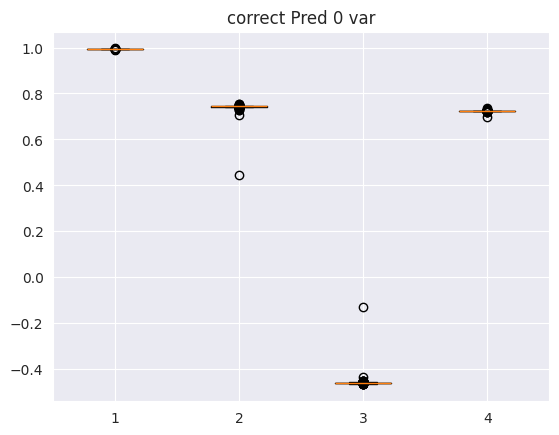

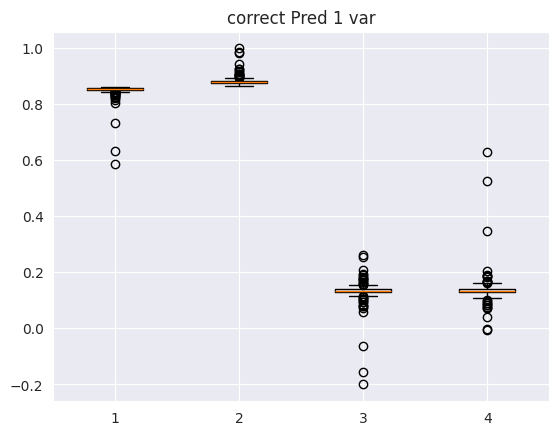

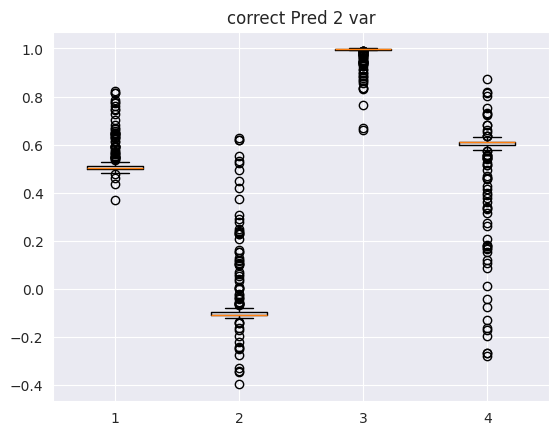

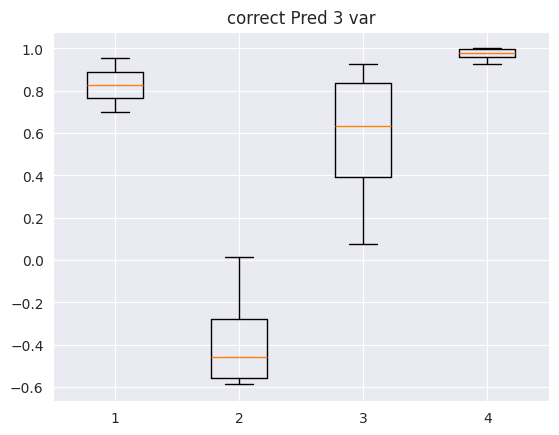

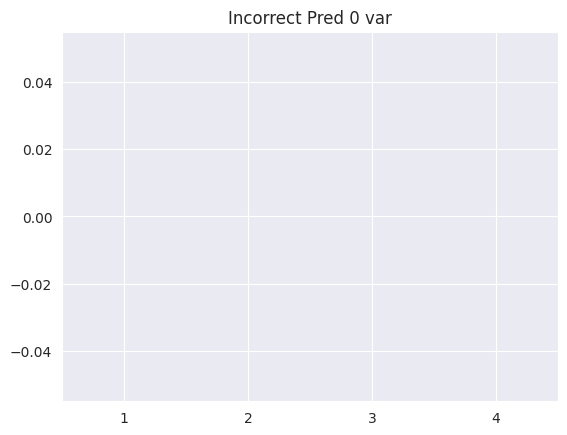

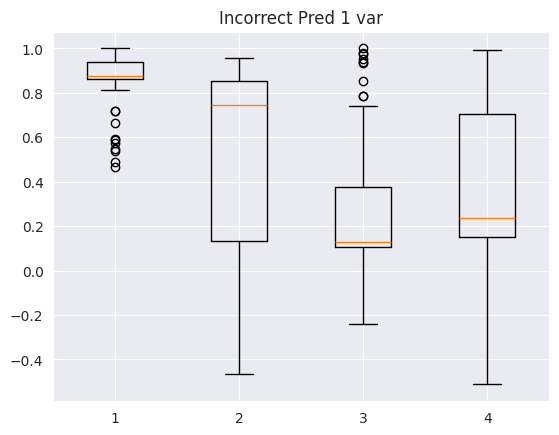

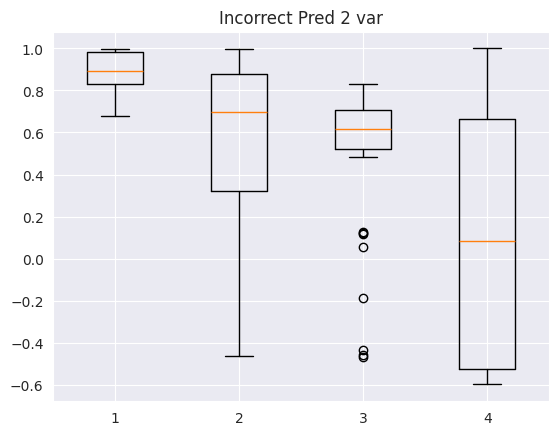

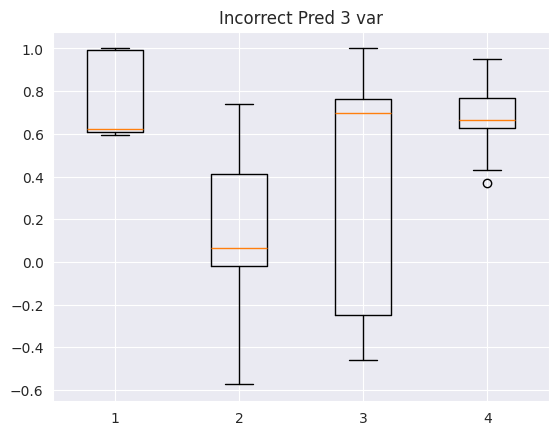

In [185]:
print(incorrect_pred_val_0.shape, correct_pred_val_0.shape)
print(incorrect_pred_val_1.shape, correct_pred_val_1.shape)
print(incorrect_pred_val_2.shape, correct_pred_val_2.shape)
print(incorrect_pred_val_3.shape, correct_pred_val_3.shape)


X = [0]
Y = [np.mean(correct_pred_val_0)]
E = [np.mean(correct_pred_val_0)]
plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 0 var')
plt.boxplot(correct_pred_val_0)
plt.show()
plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 1 var')
plt.boxplot(correct_pred_val_1)
plt.show()
plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 2 var')
plt.boxplot(correct_pred_val_2)
plt.show()
plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var')
plt.boxplot(correct_pred_val_3)
plt.show()



plt.figure("Prediction variances") # Here's the part I need
plt.title('Incorrect Pred 0 var')
plt.boxplot(incorrect_pred_val_0)
plt.show()
plt.figure("Prediction variances") # Here's the part I need
plt.title('Incorrect Pred 1 var')
plt.boxplot(incorrect_pred_val_1)
plt.show()
plt.figure("Prediction variances") # Here's the part I need
plt.title('Incorrect Pred 2 var')
plt.boxplot(incorrect_pred_val_2)
plt.show()
plt.figure("Prediction variances") # Here's the part I need
plt.title('Incorrect Pred 3 var')
plt.boxplot(incorrect_pred_val_3)
plt.show()
# plt.errorbar(x, y, e, linestyle='None', marker='^')


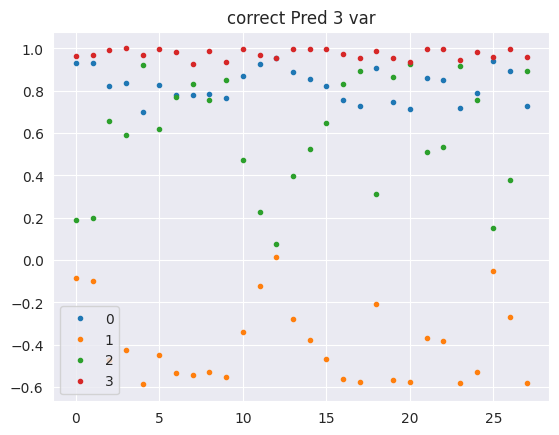

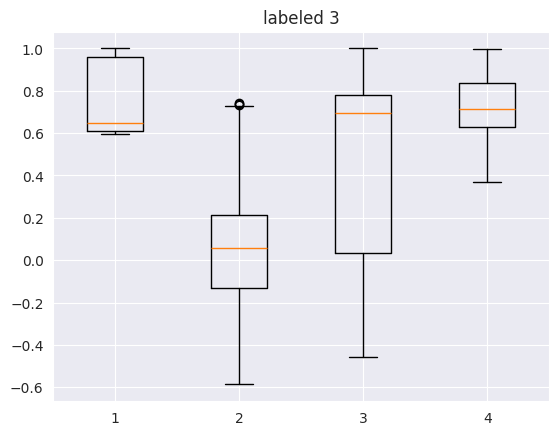

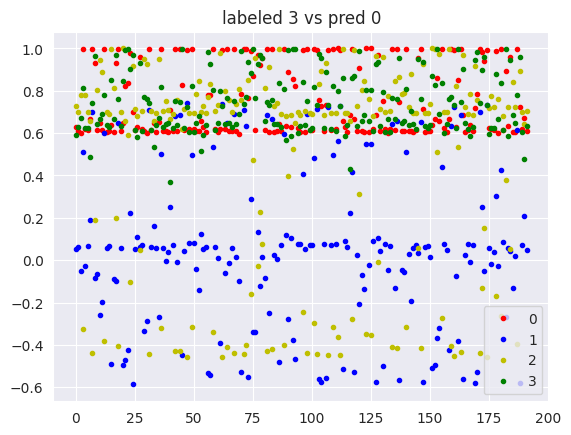

In [204]:
plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var')
plt.plot(correct_pred_val_3, '.')
plt.legend([0,1,2,3])
plt.show()

label3 = np.array(label)[:,0] == 3
pp = np.array(preds)[label3,0,:]


plt.figure("Prediction variances") # Here's the part I need
plt.title('labeled 3')
# plt.plot(pp, '.')
plt.boxplot(pp)
plt.show()


plt.figure("Prediction variances") # Here's the part I need
plt.title('labeled 3 vs pred 0')
# plt.plot(pp, '.')
plt.plot(pp[:,0], "r.")
plt.plot(pp[:,1], "b.")
plt.plot(pp[:,2], "y.")
plt.plot(pp[:,3], "g.")
plt.legend([0,1,2,3])
plt.show()


Test Image torch.Size([1, 3, 64, 64])
Test Label tensor([0])




 {0: Parameter(X0), 1: Parameter(X1), 2: Parameter(X2), 3: Parameter(X3)}
6.0 3.0
6.0 3.0 {0: Parameter(T_L10), 1: Parameter(T_L11), 2: Parameter(T_L12)}
OrthoModel_Binary_ClQ(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout4): Dropout2d(p=0.5, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=2, strid

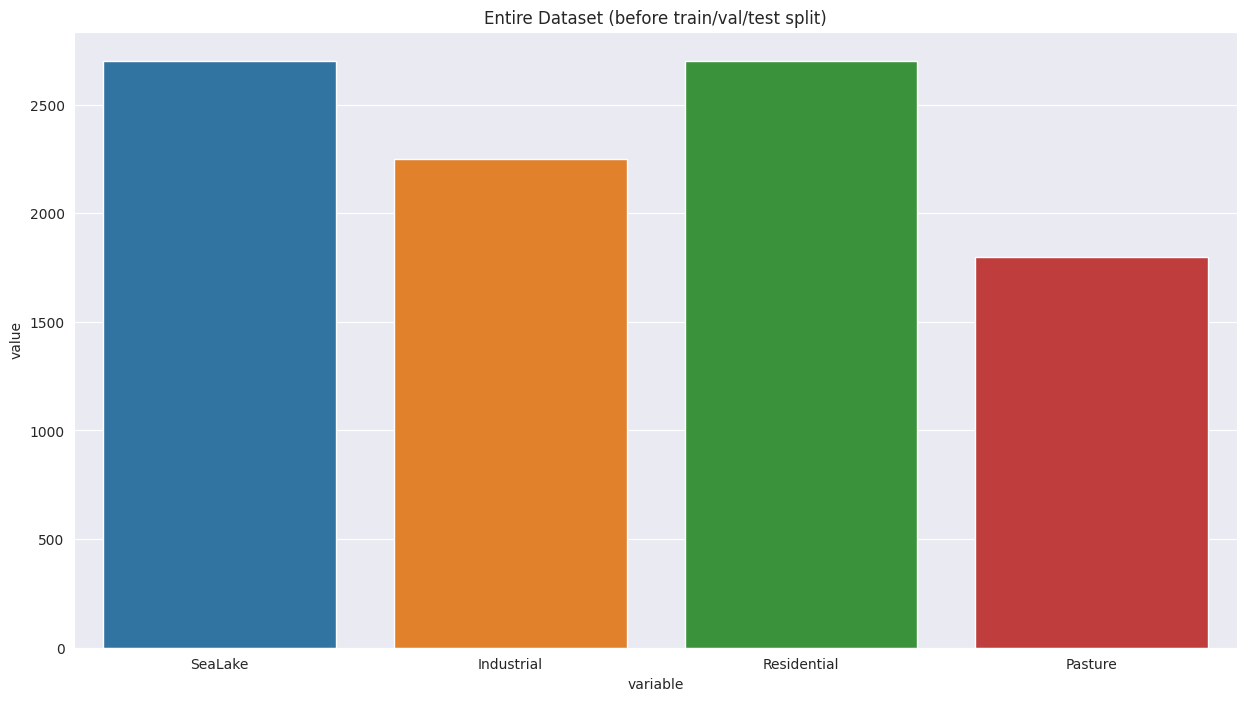

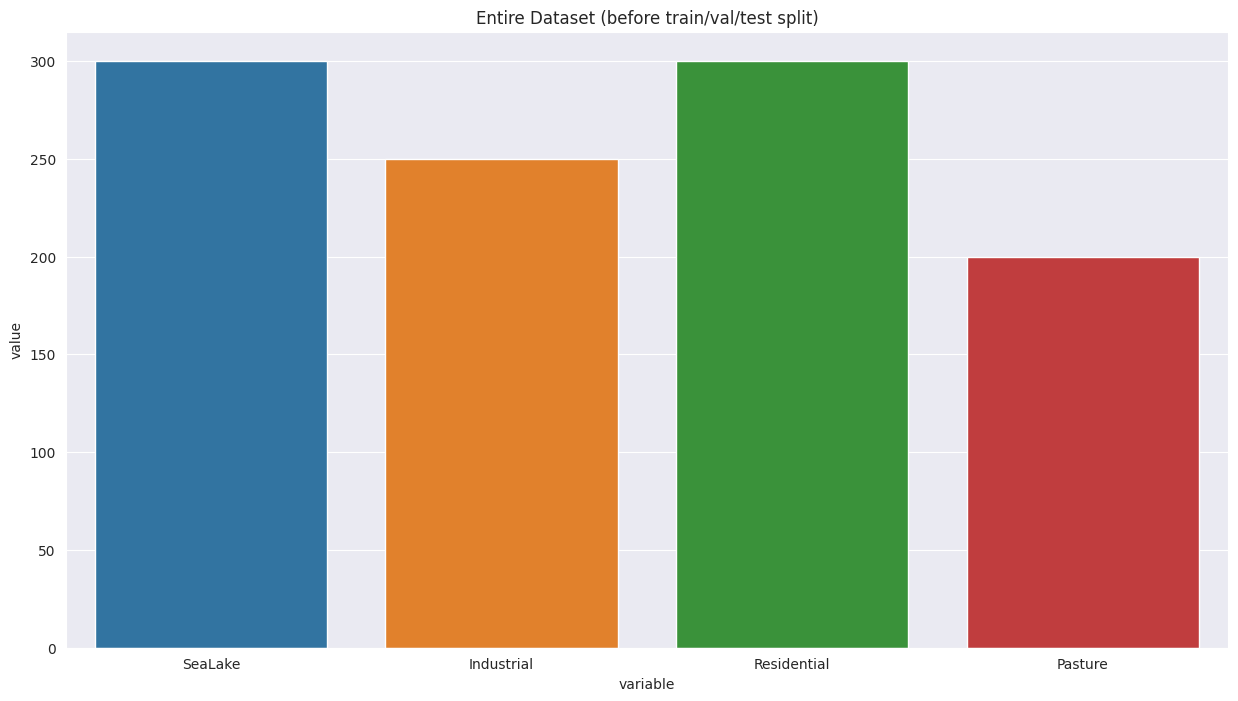

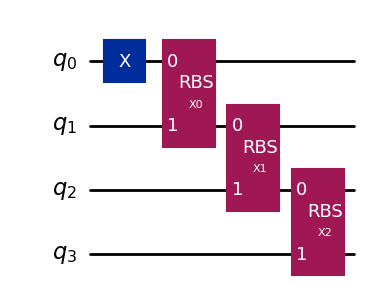

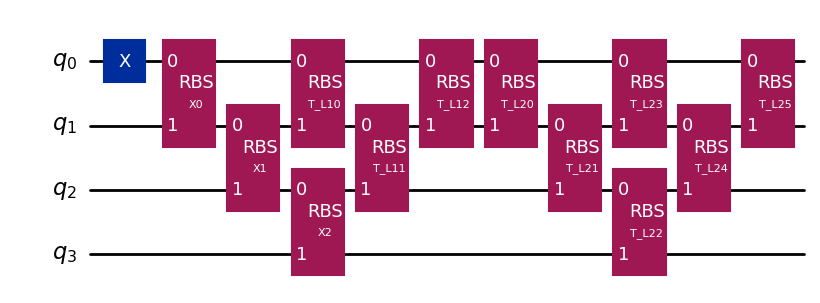

In [218]:
# test with limits and UQ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
d = next(iter(test_loader))
print("Test Image" , d[0].shape)
print("Test Label" , d[1])

# QC_NN = CreateQNN(NUM_QUBIT)
QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
# multiClassBaseModel = Base_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel = ResNet50_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel.eval()
# multiClassResnetModel.resnet_encoder.eval()

# multiClassBaseModel.eval()  # Set model to training mode


classifierModel = Binary_classifier_classical
print(classifierModel)


# optimizer = optim.Adam(classifierModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training

SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_239.pt"
Binary_classifier_classical.Train_Classical = True
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_ccc"+str(239)+".pt"
Binary_classifier_classical.Train_Classical = False
classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()

print(classifierModel)

images2 =[]
label2 = []
preds2 = []
loss_list2 = []  # Store loss history
total_loss2= []
accuracy2=[]

confusion_pred = []
confusion_target = []
confusion_image = [] 

class_min = [0.9, 0.85, 0.8, 0.9] 
class_max = [1.0, 1.0, 1.0, 1.0]
class_min = [0.9, 0.85, 0.85, 0.7] 


for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == TEST_DATA_NUMBER:
        break
    target= target.to(device)
    data= data.to(device)
    output = classifierModel(data)  # Forward pass
    # test both parts 
    o = classifierModel.classical_encoder(data) 
    norm = torch.norm(o, dim=1, keepdim=True)
        # Normalize each data point in the batch
    o = o / (norm+1e-8)
    o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
    o2 = classifierModel.quantum_part(o) 
    loss = loss_func(output, target)  # Calculate loss
    pred = o2.cpu().detach().numpy()
    # print("tmp: ", pred[0,np.argmax(pred)], class_min[np.argmax(pred)])
    if pred[0,np.argmax(pred)] < class_min[np.argmax(pred)]:
        print("skipping: ", pred[0,np.argmax(pred)], class_min[np.argmax(pred)])
        confusion_pred.append(pred)
        confusion_target.append(target.cpu().detach().numpy())
        confusion_image.append(data.cpu().detach().numpy())
        continue
    p = np.argmax(pred)
    if np.argmax(pred) == 0 and pred[0,0] < 0.98 and pred[0,3] > 0.65:
        p = 3
    if np.argmax(pred) == 0 and pred[0,0] < 0.98 and pred[0,2] > 0.75:
        p = 2
    if np.argmax(pred) == 2 and pred[0,2] < 0.91 and pred[0,3] > 0.8:
        p = 3

    if p != target.cpu().detach().numpy()[0]:
        print("Mismatch", pred, np.argmax(pred), target.cpu().detach().numpy() )
    
    preds2.append(pred)
    
    label2.append(target.cpu().detach().numpy())
    images2.append(data.cpu().detach().numpy())
    total_loss2.append(loss.item())
    # print(str(np.int32(test_target == test_pred)))
    accuracy_test2 = np.int32(label2[-1] == p)
    accuracy2.append(accuracy_test2)

    # accuracy.append(np.argmax(pred[-1]))

loss_list2.append(sum(total_loss2) / len(total_loss2))
print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list2[-1]))
print("Testing \t accuracy: ", np.sum(accuracy2)/len(accuracy2))



# test with cross_images

In [43]:
 
IMAGE_SIZE = 64
BATCH_SIZE = 256
NUM_QUBIT = 4
TEST_DATA_NUMBER= 1000
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_"
root_dir_binary = "/home/aws_install/projects/QCML/QNN4EO/Dataset/Small_Train/"
root_dir_binary_test = "/home/aws_install/projects/QCML/QNN4EO/Dataset/Cross_Image_test/"
backup_acc_data = None

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
# dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

# train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
d = next(iter(test_loader))
print("Test Image" , d[0].shape)
print("Test Label" , d[1])

# QC_NN = CreateQNN(NUM_QUBIT)
QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
# multiClassBaseModel = Base_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel = ResNet50_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel.eval()
# multiClassResnetModel.resnet_encoder.eval()

# multiClassBaseModel.eval()  # Set model to training mode


classifierModel = Binary_classifier_classical
print(classifierModel)


# optimizer = optim.Adam(classifierModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
loss_list = []  # Store loss history
total_loss= []
accuracy=[]
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_239.pt"
Binary_classifier_classical.Train_Classical = True
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_ccc"+str(220)+".pt"
Binary_classifier_classical.Train_Classical = False
classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()

print(classifierModel)

images =[]
label = []
preds = []
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == TEST_DATA_NUMBER:
        break
    if target.cpu().detach().numpy() != 3:
        continue
    target= target.to(device)
    data= data.to(device)
    output = classifierModel(data)  # Forward pass
    # test both parts 
    o = classifierModel.classical_encoder(data) 
    norm = torch.norm(o, dim=1, keepdim=True)
        # Normalize each data point in the batch
    o = o / (norm+1e-8)
    o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
    o2 = classifierModel.quantum_part(o) 
    loss = loss_func(output, target)  # Calculate loss
    preds.append(o2.cpu().detach().numpy())
    label.append(target.cpu().detach().numpy())
    images.append(data.cpu().detach().numpy())
    total_loss.append(loss.item())
    # print(str(np.int32(test_target == test_pred)))
    accuracy_test = np.int32(label[-1] == np.argmax(preds[-1]))
    accuracy.append(accuracy_test)

    # accuracy.append(np.argmax(pred[-1]))

loss_list.append(sum(total_loss) / len(total_loss))
print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
print("Testing \t accuracy: ", np.sum(accuracy)/len(accuracy))

In [ ]:
print(np.shape(preds) ,np.shape(label))
print(np.min(preds),np. max(preds),np. min(label), np.max(label))
argmax_preds = np.argmax(np.array(preds)[:,0,:], axis =1 )
print(argmax_preds.shape, argmax_preds.min(), argmax_preds.max())


cls = 3
label3 = (cls== np.array(label)[:,0])
pred_val_3 = np.array(preds)[label3,0,:]

print(pred_val_3.shape)

plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var 0 ')
# plt.boxplot(pred_val_3)
plt.plot(pred_val_3[:,0], "b.")
plt.plot([pred_val_3[:,0].min(), pred_val_3[:,0].max()], "r.")
plt.plot([0,750], [pred_val_3[:,0].mean(), pred_val_3[:,0].mean()], "r")
plt.show()

plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var')
# plt.boxplot(pred_val_3)
plt.plot(pred_val_3[:,1], "b.")
plt.plot([pred_val_3[:,1].min(), pred_val_3[:,1].max()], "r.")
plt.plot([0,750], [pred_val_3[:,1].mean(), pred_val_3[:,1].mean()], "r")
plt.show()

plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var')
# plt.boxplot(pred_val_3)
plt.plot(pred_val_3[:,2], "b.")
plt.plot([pred_val_3[:,2].min(), pred_val_3[:,2].max()], "r.")
plt.plot([0,750], [pred_val_3[:,2].mean(), pred_val_3[:,2].mean()], "r")
plt.show()

plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var')
# plt.boxplot(pred_val_3)
plt.plot(pred_val_3[:,3], "b.")
plt.plot([pred_val_3[:,3].min(), pred_val_3[:,3].max()], "r.")
plt.plot([0,750], [pred_val_3[:,3].mean(), pred_val_3[:,3].mean()], "r")
plt.show()

plt.figure("Prediction variances") # Here's the part I need
plt.title('correct Pred 3 var')
plt.boxplot(pred_val_3)
plt.show()

Test Image torch.Size([1, 3, 64, 64])
Test Label tensor([3])




 {0: Parameter(X0), 1: Parameter(X1), 2: Parameter(X2), 3: Parameter(X3)}
6.0 3.0
6.0 3.0 {0: Parameter(T_L10), 1: Parameter(T_L11), 2: Parameter(T_L12)}
OrthoModel_Binary_ClQ(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout4): Dropout2d(p=0.5, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=2, strid

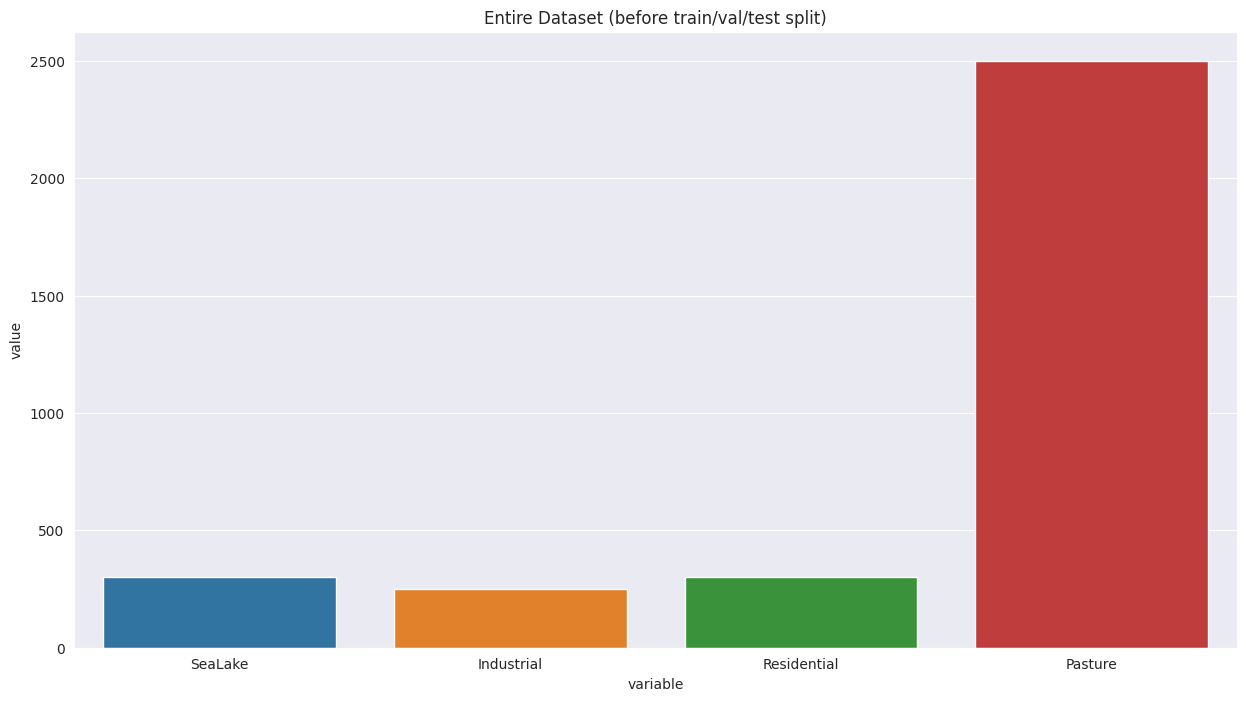

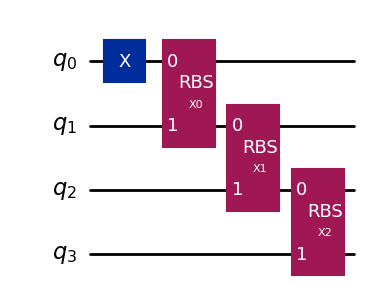

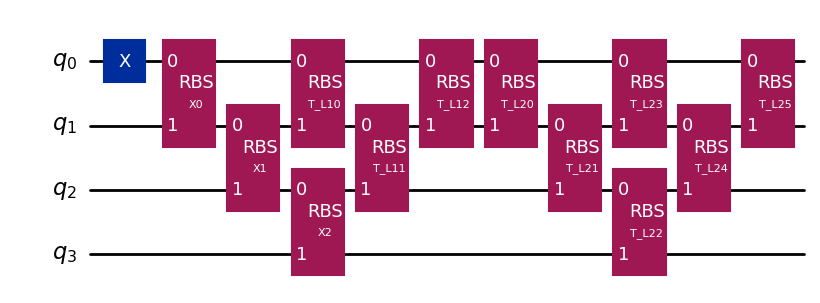

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
# dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])

# train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
d = next(iter(test_loader))
print("Test Image" , d[0].shape)
print("Test Label" , d[1])

# QC_NN = CreateQNN(NUM_QUBIT)
QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
# multiClassBaseModel = Base_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel = ResNet50_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel.eval()
# multiClassResnetModel.resnet_encoder.eval()

# multiClassBaseModel.eval()  # Set model to training mode


classifierModel = Binary_classifier_classical
print(classifierModel)


# optimizer = optim.Adam(classifierModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
loss_list = []  # Store loss history
total_loss= []
accuracy=[]
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_239.pt"
Binary_classifier_classical.Train_Classical = True
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_ccc"+str(220)+".pt"
Binary_classifier_classical.Train_Classical = False
classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()

print(classifierModel)

images =[]
label = []
preds = []
p = []
dd = []

class_min = [0.94, 0.9, 0.85, 0.92] 
class_max = [1.0, 1.0, 1.0, 1.0]

neglect_image = [0.99, 0.99, 0.99, 0.99] 
neglect_image2 = [0.75,0.4,0.5,0.75]

for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == TEST_DATA_NUMBER:
        break
    if target.cpu().detach().numpy()[0] != 3:
        continue
    dd.append(target.cpu().detach().numpy())
    target= target.to(device)
    data= data.to(device)
    output = classifierModel(data)  # Forward pass
    # test both parts 
    o = classifierModel.classical_encoder(data) 
    norm = torch.norm(o, dim=1, keepdim=True)
        # Normalize each data point in the batch
    o = o / (norm+1e-8)
    o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
    o2 = classifierModel.quantum_part(o) 
    loss = loss_func(output, target)  # Calculate loss
    pred = o2.cpu().detach().numpy()
    
    p.append(o2.cpu().detach().numpy())
    if pred[0,0] < neglect_image[0] and pred[0,1] < neglect_image[1] and pred[0,2] < neglect_image[2] and pred[0,3] < neglect_image[3]:
        print("skipping: i", pred[0,np.argmax(pred)], class_min[np.argmax(pred)], batch_idx )
    else:
        preds.append(o2.cpu().detach().numpy())
        label.append(target.cpu().detach().numpy())
        images.append(data.cpu().detach().numpy())
        total_loss.append(loss.item())
        # print(str(np.int32(test_target == test_pred)))
        accuracy_test = np.int32(label[-1] == np.argmax(preds[-1]))
        accuracy.append(accuracy_test)

        # accuracy.append(np.argmax(pred[-1]))

loss_list.append(sum(total_loss) / len(total_loss))
print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
print("Testing \t accuracy: ", np.sum(accuracy)/len(accuracy))

(1000, 1, 4)
747


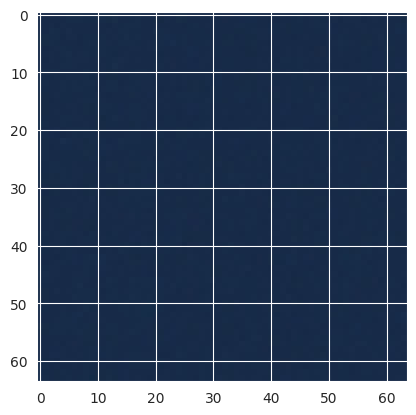

In [215]:

print(np.shape(preds))
print(len(dd))

im = np.transpose(images[2][0,:,:,:], (1, 2, 0))
plt.imshow(im)

In [219]:
d = (np.array(label) == 3)
print(np.int32(d).sum())

192


In [163]:
np.shape(label)

(339, 1)

In [4]:
np.shape(label2), np.shape(preds2)

from sklearn import metrics
pred_labels = np.array(preds2)[:,0,:].argmax(axis=1)
target_labels = np.array(label2)[:,0]

confusion_matrix = metrics.confusion_matrix(target_labels, pred_labels)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in dataSet.class_folders],
                  columns = [i for i in dataSet.class_folders])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)



NameError: name 'label2' is not defined

In [3]:
steps_y= 0.03
for cls in range(4):

    argmax_preds = np.argmax(np.array(preds)[:,0,:], axis =1 )

    correct_classifictaion= (argmax_preds == np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
    incorrect_classifictaion = (argmax_preds != np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
    total_classifictaion =   np.array(label)[:,0] == cls

    correct_pred_val = np.array(preds)[correct_classifictaion,0,:]
    incorrect_pred_val = np.array(preds)[incorrect_classifictaion,0,:]
    total_pred_val = np.array(preds)[total_classifictaion,0,:]
    plt.figure("Prediction variances for correct classification", figsize=(6,12)) # Here's the part I need
    plt.title('Distribution for class '+str(cls)+" images for correct classification" )
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1, step=steps_y))
    plt.boxplot(correct_pred_val, patch_artist = True ,boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
    plt.show()
    plt.figure("Prediction variances for incorrect classification", figsize=(6,12)) # Here's the part I need
    plt.title('Distribution for class '+str(cls)+" images for incorrect classification" )
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1, step=steps_y))
    plt.boxplot(incorrect_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
    plt.show()
    plt.figure("Prediction variances for all classification", figsize=(6,12)) # Here's the part I need
    plt.title('Distribution for class '+str(cls)+" images for all classification" )
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1, step=steps_y))
    plt.boxplot(total_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
    plt.show()


# all in class 5 and 6 

cls = 4

total_classifictaion =   np.array(label)[:,0] == cls
total_pred_val = np.array(preds)[total_classifictaion,0,:]
plt.figure("Prediction variances for all classification", figsize=(6,12)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(total_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

cls = 5

total_classifictaion =   np.array(label)[:,0] == cls
total_pred_val = np.array(preds)[total_classifictaion,0,:]
plt.figure("Prediction variances for all classification", figsize=(6,12)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(total_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()


NameError: name 'preds' is not defined

Test Image torch.Size([1, 3, 64, 64])
Test Label tensor([2])




 {0: Parameter(X0), 1: Parameter(X1), 2: Parameter(X2), 3: Parameter(X3)}
6.0 3.0
6.0 3.0 {0: Parameter(T_L10), 1: Parameter(T_L11), 2: Parameter(T_L12)}
OrthoModel_Binary_ClQ(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout4): Dropout2d(p=0.5, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=2, strid

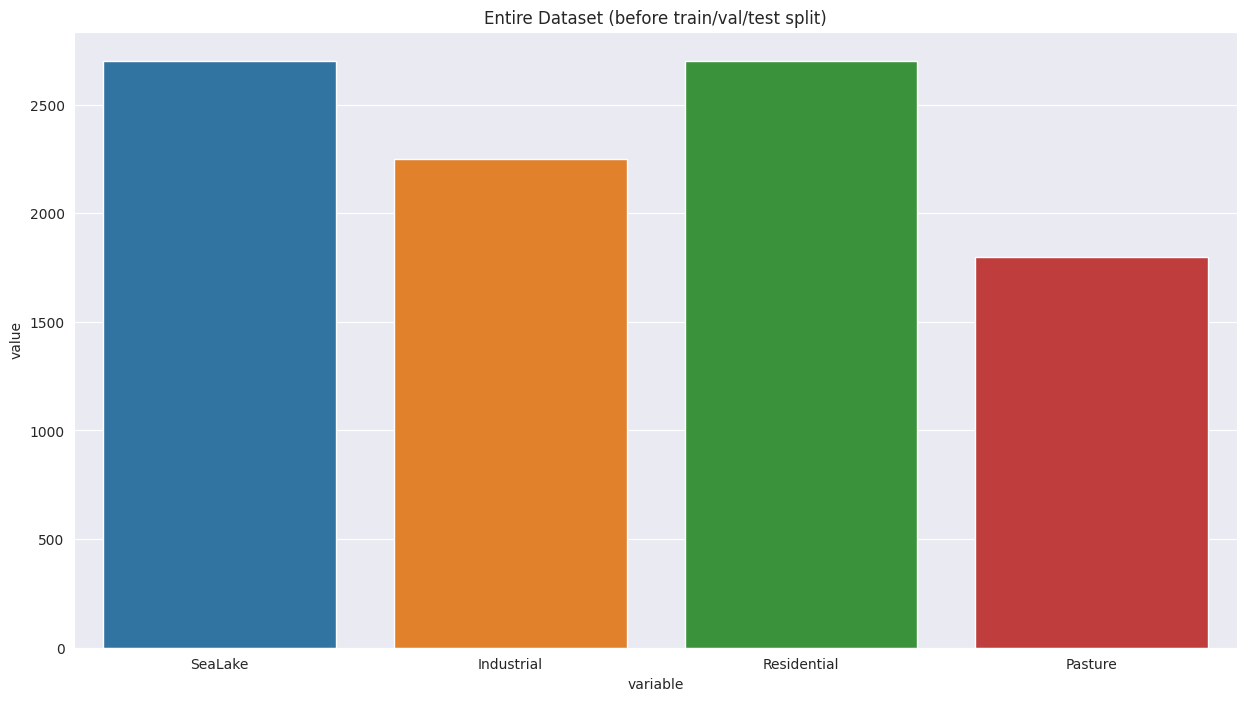

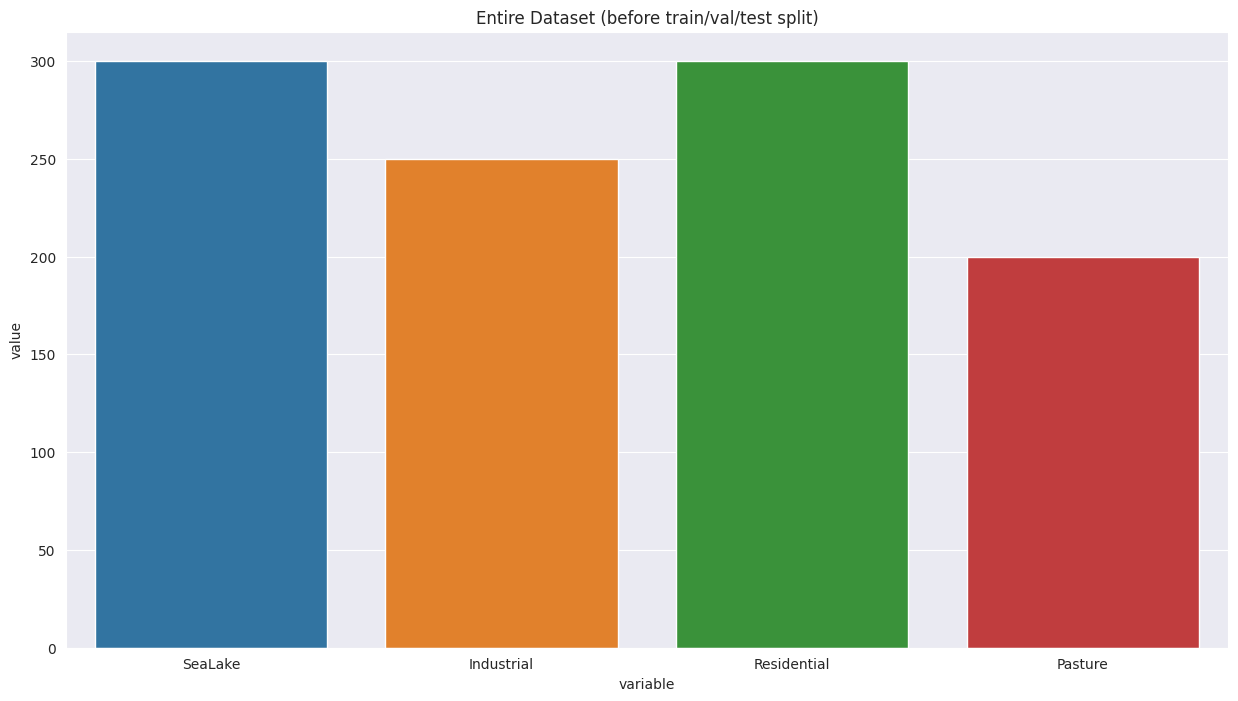

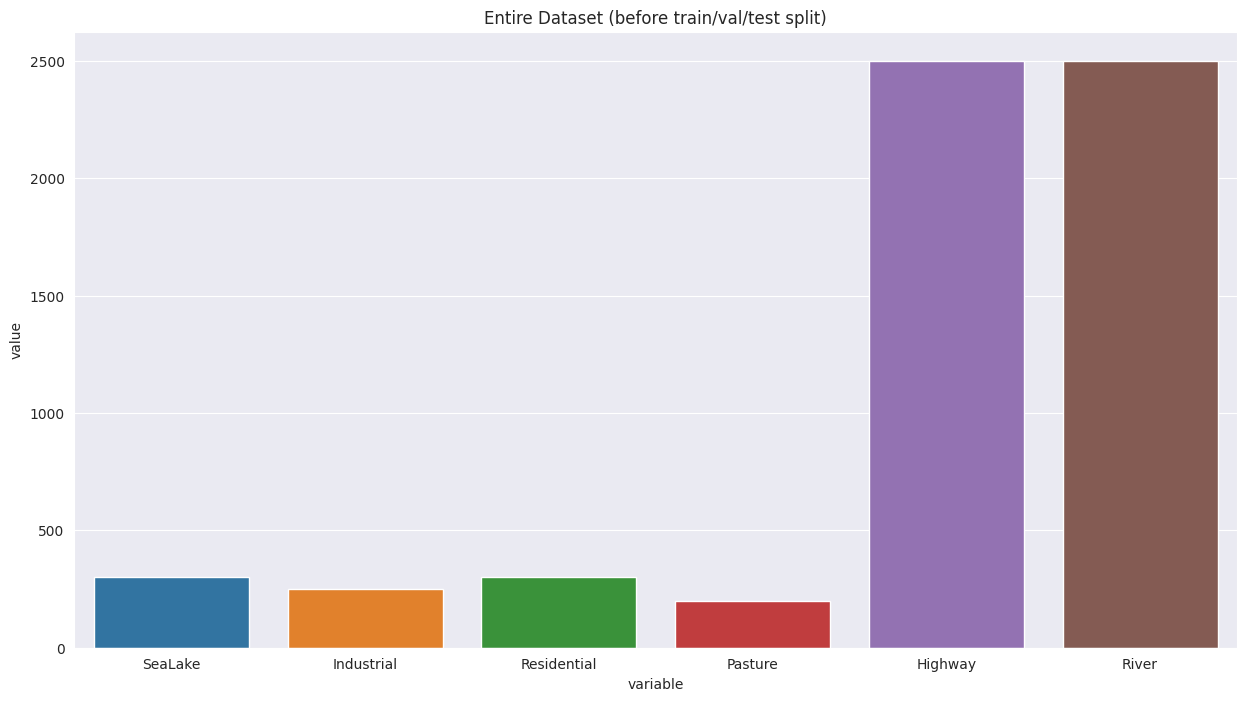

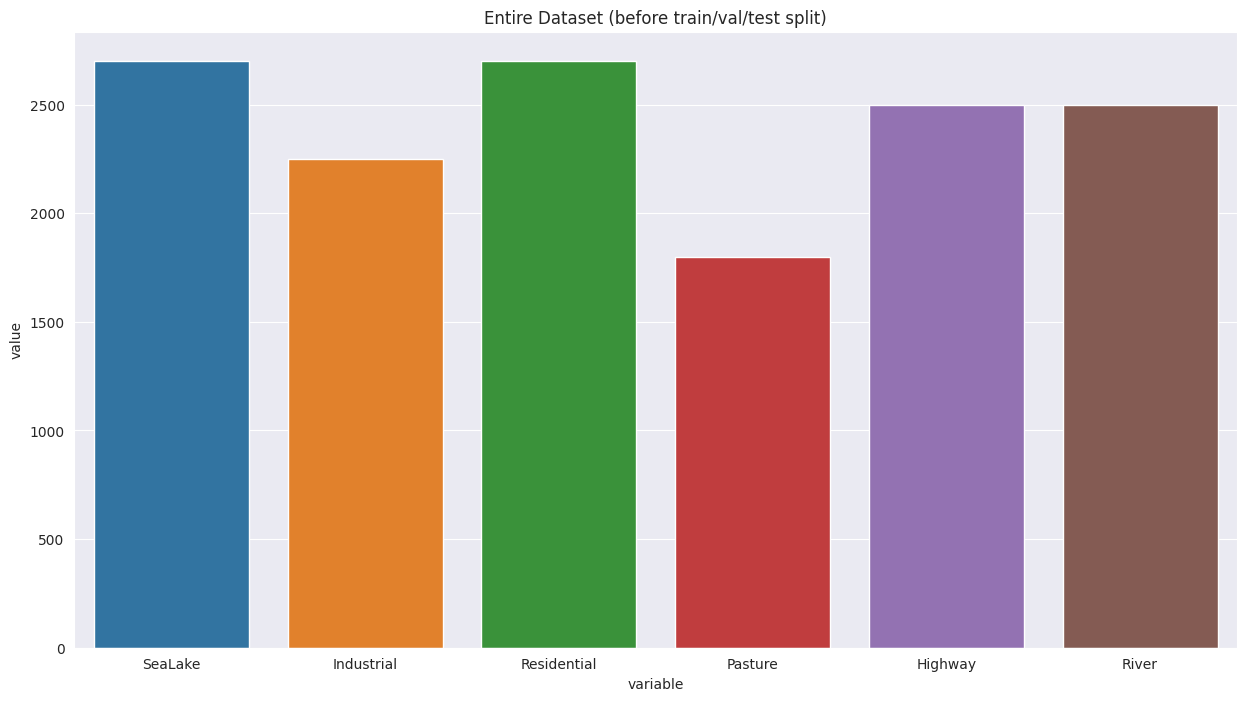

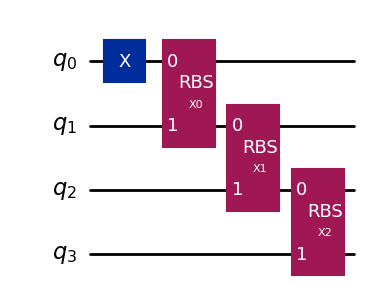

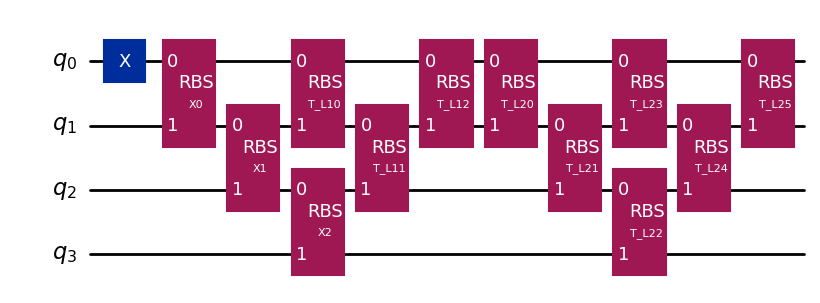

In [24]:
from utils import MultiClassImageDataset6, MultiClassImageDataset6_all
def process_target_1Hot(target):
    target = F.one_hot(target, num_classes=4)
    target =  target.to(torch.float32)
    return target

root_dir_binary_test_UQ = "/home/aws_install/projects/QCML/QNN4EO/Dataset/Cross_Image_test/"
UQ_TEST = False
val_class = [0.97,0.97 ,0.98,0.74]

# class 0 : min 0.96 to 1, all other -1 to 0.85
# class 1 : max 0.96, 0.9  to 1,-1 to 85 , -1 to 85
# class 2 : max 0.96,-1 to 85 , 0.89 to 1, -1 to 85
# class 3 : max 0.96,-1 to 85 , 0.89 to 1, -1 to 85

val_class_min_0 = [0.97, 0, 0, 0]
val_class_max_0 = [1,1 ,1,1]

val_class_min_1 = [-1, 0.9, 0, 0]
val_class_max_1 = [0.97, 1 ,1,1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style('darkgrid')

image_transforms = preprocessing(IMAGE_SIZE, device)
dataSet = MultiClassImageDataset(root_dir_binary, image_transforms["train"])
dataSet_test = MultiClassImageDataset(root_dir_binary_test, image_transforms["train"])
dataSet_UQTest = MultiClassImageDataset6(root_dir_binary_test_UQ, image_transforms["train"])
dataSet_6_Train = MultiClassImageDataset6_all(root_dir_binary_test_UQ, image_transforms["train"])

train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=1)
test_loader = DataLoader(dataset=dataSet_test, shuffle=True, batch_size=1)
test_loader_UQ = DataLoader(dataset=dataSet_UQTest, shuffle=True, batch_size=1)
test_loader_all_6 = DataLoader(dataset=dataSet_6_Train, shuffle=True, batch_size=1)


d = next(iter(test_loader))
print("Test Image" , d[0].shape)
print("Test Label" , d[1])

# QC_NN = CreateQNN(NUM_QUBIT)
QC_NN = CreateOrthogonalQNN4(NUM_QUBIT,  SAMPLER = False)
Binary_classifier_classical = OrthoModel_Binary_ClQ(QC_NN, NUM_QUBIT, Train_Classical = True).to(device)
# multiClassBaseModel = Base_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel = ResNet50_Model(QC_NN, NUM_QUBIT).to(device)
# multiClassResnetModel.eval()
# multiClassResnetModel.resnet_encoder.eval()



# multiClassBaseModel.eval()  # Set model to training mode


classifierModel = Binary_classifier_classical
print(classifierModel)
MSEL = False

# optimizer = optim.Adam(classifierModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()
if MSEL:
    loss_func = MSELoss()

# Start training
loss_list = []  # Store loss history
total_loss= []
accuracy=[]
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_239.pt"
Binary_classifier_classical.Train_Classical = True
SAVE_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_cccc"+str(20)+".pt"
Binary_classifier_classical.Train_Classical = False
classifierModel.load_state_dict(torch.load(SAVE_PATH, weights_only=True))
classifierModel.eval()

print(classifierModel)
skipped_image = []
skipped_target = []

images =[]
label = []
preds = []
skipped = 0
unskipped = 0

for batch_idx, (data, target) in enumerate(test_loader_all_6):
    # if batch_idx == TEST_DATA_NUMBER:
    #     break
    target= target.to(device)
    data= data.to(device)
    output = classifierModel(data)  # Forward pass
    # test both parts 
    o = classifierModel.classical_encoder(data) 
    norm = torch.norm(o, dim=1, keepdim=True)
        # Normalize each data point in the batch
    o = o / (norm+1e-8)
    o = classifierModel.encode_amplitudes_NQubit(o, NUM_QUBIT)
    o2 = classifierModel.quantum_part(o) 

    pr = o2.cpu().detach().numpy()
    p = np.argmax(pr)
    p2 = np.argmax(pr)
    if UQ_TEST:
        if pr[:,3] > val_class[3]:
            if pr[:,3]> 0.74 and pr[:,1] < 0:
                p = 3
            else:
                print("skipping this image for further analysis: ", batch_idx, p, p2)
                skipped_image.append(data)
                skipped_target.append(target)
                skipped = skipped +1
                continue
        elif  pr[:,2] > val_class[2]:
            p=2
        elif pr[:,1] > val_class[1] :
            p=1
        elif pr[:,0] > val_class[0]:
            p=0
        else:
            print("skipping this image for further analysis: ", batch_idx, p, p2, "x")
            skipped_image.append(data)
            skipped_target.append(target)
            skipped = skipped +1
            continue
    
    unskipped = unskipped + 1
    print(p,p2, batch_idx)
    
    # if MSEL:
    #     target_2 = process_target_1Hot(target)
    #     target_2= target_2.to(device)
    #     output =  F.sigmoid(10*output)

    # loss = loss_func(output, target_2)  # Calculate loss
    preds.append(pr)
    label.append(target.cpu().detach().numpy())
    images.append(data.cpu().detach().numpy())
    # total_loss.append(loss.item())
    # print(str(np.int32(test_target == test_pred)))
    accuracy_test = np.int32(label[-1] == p )
    accuracy.append(accuracy_test)

    # accuracy.append(np.argmax(pred[-1]))

# loss_list.append(sum(total_loss) / len(total_loss))
# print("Testing [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (1 + 1) , loss_list[-1]))
print("Testing \t accuracy: ", np.sum(accuracy)/len(accuracy))
print("Total Skipped images : ", skipped, " and Unskipped: ", unskipped)


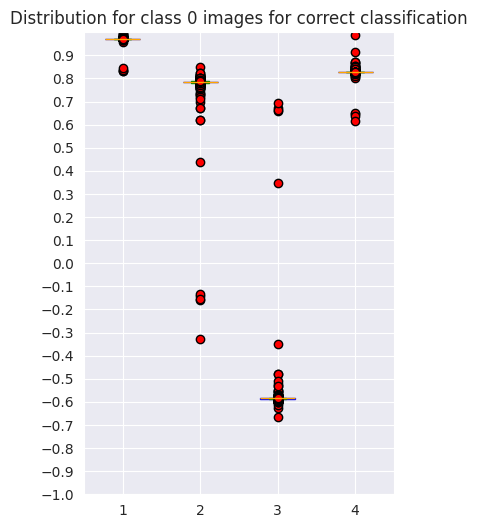

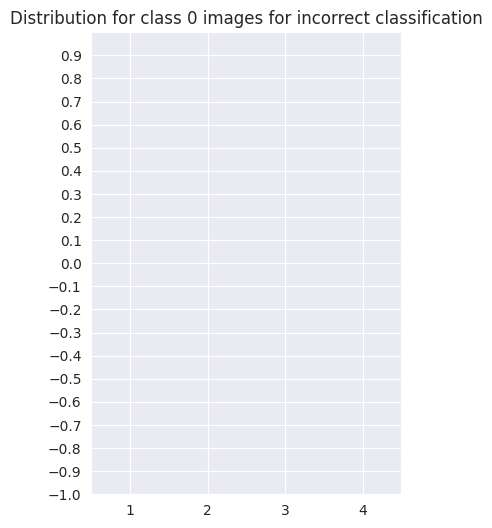

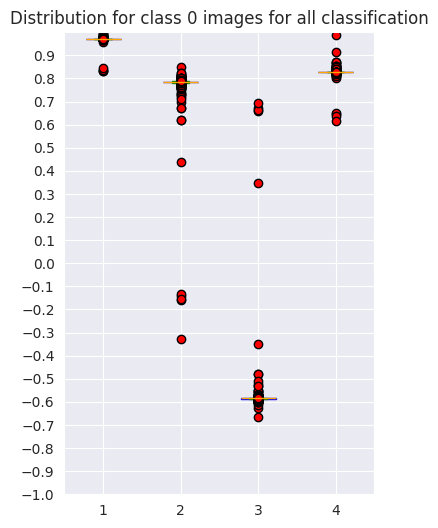

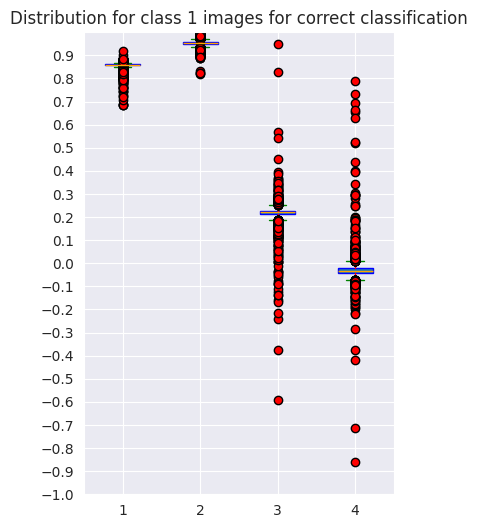

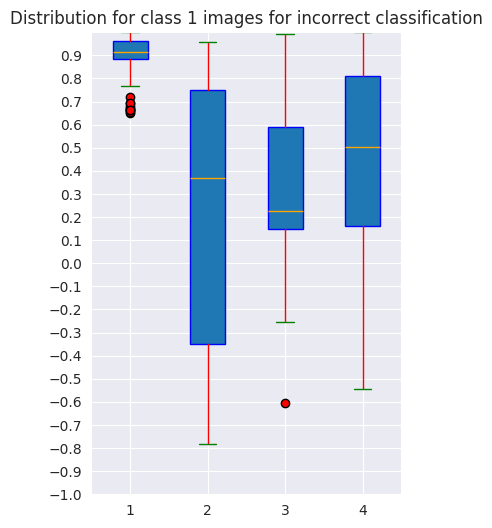

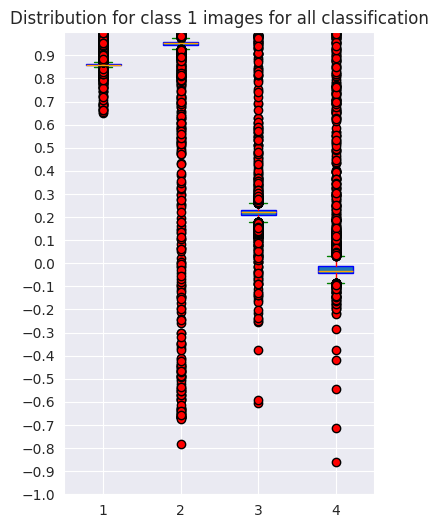

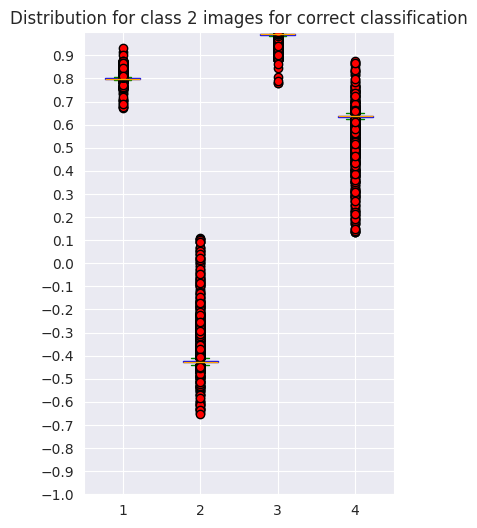

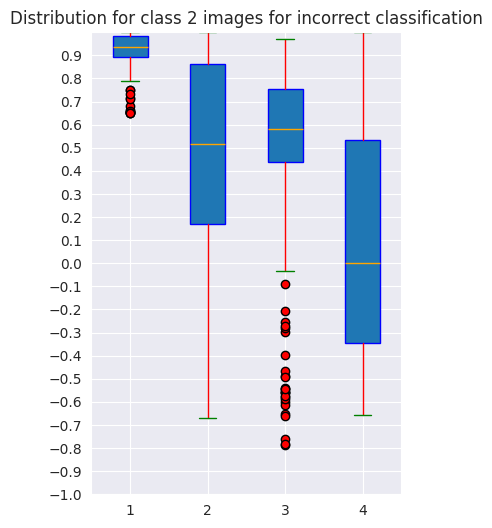

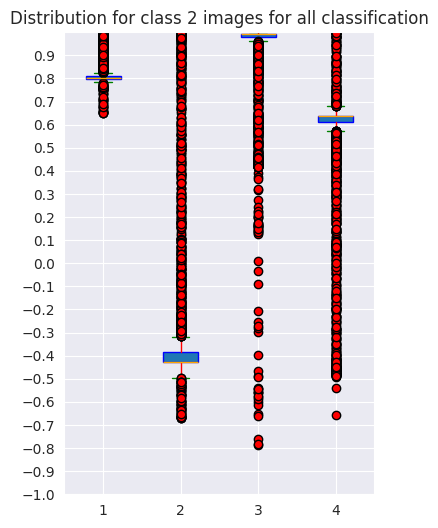

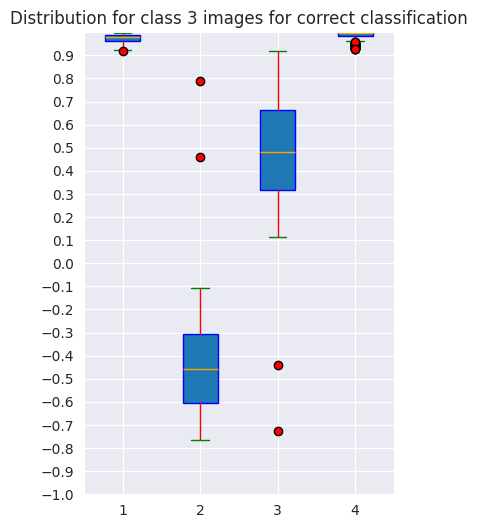

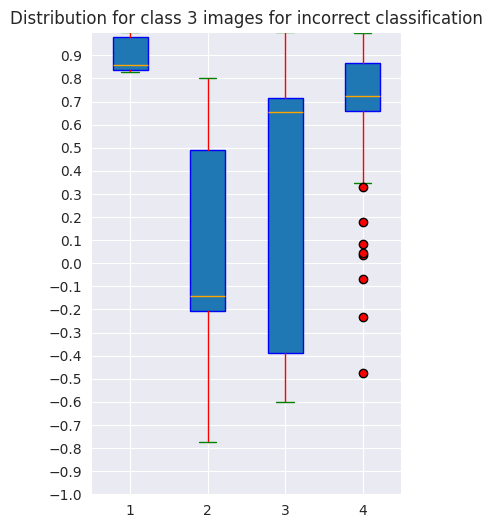

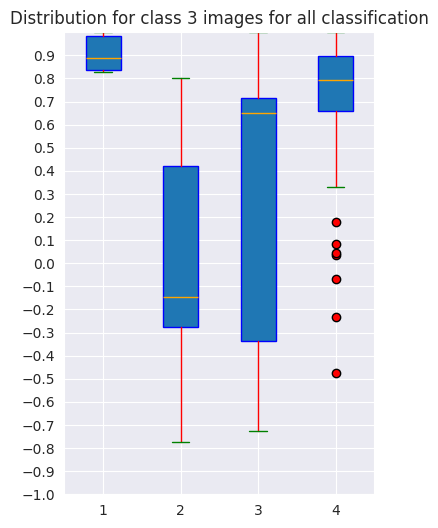

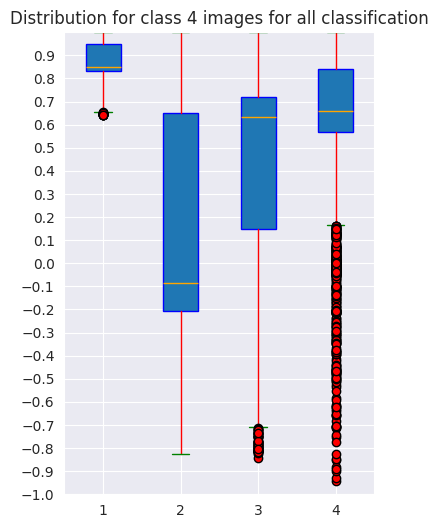

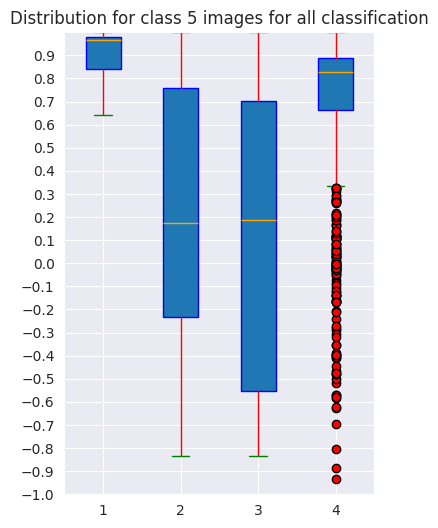

In [25]:
steps_y= 0.1
for cls in range(4):

    argmax_preds = np.argmax(np.array(preds)[:,0,:], axis =1 )

    correct_classifictaion= (argmax_preds == np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
    incorrect_classifictaion = (argmax_preds != np.array(label)[:,0])  &  ( np.array(label)[:,0] == cls )
    total_classifictaion =   np.array(label)[:,0] == cls

    correct_pred_val = np.array(preds)[correct_classifictaion,0,:]
    incorrect_pred_val = np.array(preds)[incorrect_classifictaion,0,:]
    total_pred_val = np.array(preds)[total_classifictaion,0,:]
    plt.figure("Prediction variances for correct classification", figsize=(4,6)) # Here's the part I need
    plt.title('Distribution for class '+str(cls)+" images for correct classification" )
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1, step=steps_y))
    plt.boxplot(correct_pred_val, patch_artist = True ,boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
    plt.show()
    plt.figure("Prediction variances for incorrect classification", figsize=(4,6)) # Here's the part I need
    plt.title('Distribution for class '+str(cls)+" images for incorrect classification" )
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1, step=steps_y))
    plt.boxplot(incorrect_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
    plt.show()
    plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
    plt.title('Distribution for class '+str(cls)+" images for all classification" )
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1, step=steps_y))
    plt.boxplot(total_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
    plt.show()


# all in class 5 and 6 

cls = 4

total_classifictaion =   np.array(label)[:,0] == cls
total_pred_val = np.array(preds)[total_classifictaion,0,:]
plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(total_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

cls = 5

total_classifictaion =   np.array(label)[:,0] == cls
total_pred_val = np.array(preds)[total_classifictaion,0,:]
plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(total_pred_val, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()


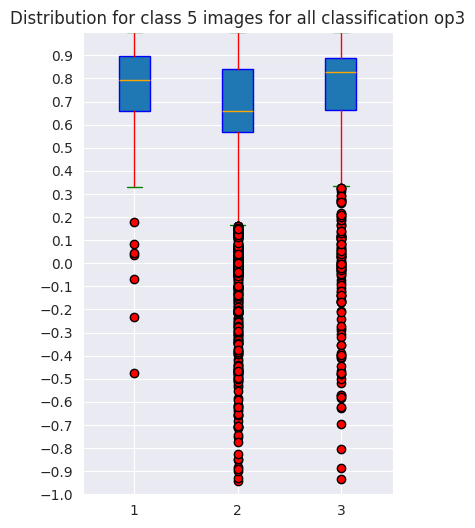

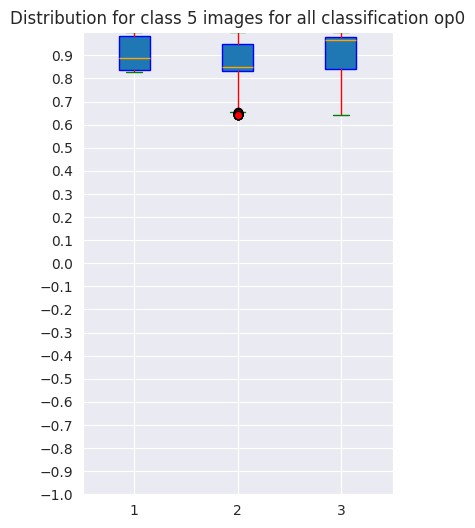

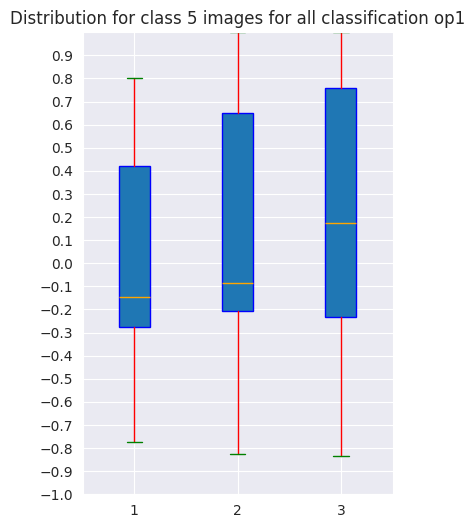

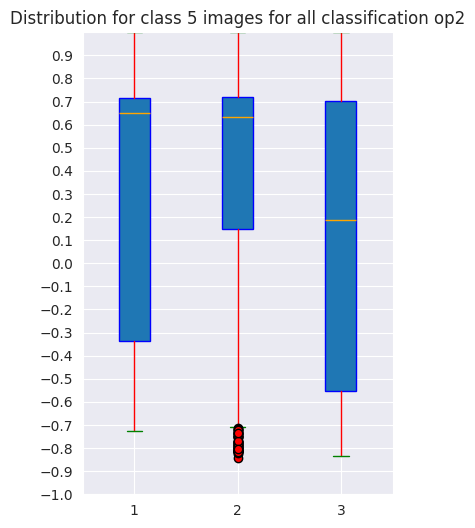

In [26]:
cls = 5

total_classifictaion_3 =   np.array(label)[:,0] == 3
total_classifictaion_4 =   np.array(label)[:,0] == 4
total_classifictaion_5 =   np.array(label)[:,0] == 5
total_pred_val3 = np.array(preds)[total_classifictaion_3,0,:]
total_pred_val4 = np.array(preds)[total_classifictaion_4,0,:]
total_pred_val5 = np.array(preds)[total_classifictaion_5,0,:]

list_data = [total_pred_val3[:,3], total_pred_val4[:,3], total_pred_val5[:,3]]
plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification op3" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(list_data, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

list_data = [total_pred_val3[:,0], total_pred_val4[:,0], total_pred_val5[:,0]]
plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification op0" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(list_data, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()


list_data = [total_pred_val3[:,1], total_pred_val4[:,1], total_pred_val5[:,1]]
plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification op1" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(list_data, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

list_data = [total_pred_val3[:,2], total_pred_val4[:,2], total_pred_val5[:,2]]
plt.figure("Prediction variances for all classification", figsize=(4,6)) # Here's the part I need
plt.title('Distribution for class '+str(cls)+" images for all classification op2" )
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1, step=steps_y))
plt.boxplot(list_data, patch_artist = True, boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

In [21]:
np.sum(np.array(label)[:,0] == 5)


dataSet_UQTest.class_folders

['SeaLake', 'Industrial', 'Residential', 'Pasture', 'Highway', 'River']

In [27]:
from sklearn import tree
arr_pred = np.array(preds)[:,0,:]
arr_label =  np.array(label)[:,0]
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(arr_pred, arr_label)

In [28]:
arr_pred2 = np.array(preds)[:,0,:]
arr_label2 = np.array(label)[:,0]
arr_pp = clf.predict(arr_pred2) 


In [29]:
t  = (arr_pp == arr_label2)
np.shape(t)
print(np.sum(np.int32(t))/len(t))

t2 = (arr_label2 == 4) | (arr_label2 == 5)
t2_p = (arr_pp == 4) | (arr_pp == 5)
arr_pp[t2_p] = 6
arr_label2[t2] = 6
t2  = (arr_pp == arr_label2)
np.shape(t2)
print(np.sum(np.int32(t2))/len(t2))


0.7532871972318339
0.8239446366782007


475
[False False False  True False False  True  True  True False  True False
 False False  True False False False  True  True  True False  True False
 False False False  True  True  True False False False False False  True
 False False False False  True  True False  True  True False False False
  True  True False False  True False False  True False  True  True False
 False False False  True False  True False  True  True False  True  True
 False  True False False  True False  True  True False False  True  True
  True  True  True False  True  True False  True  True  True  True  True
  True False  True  True False  True False  True  True  True  True False
 False  True  True  True False  True False False  True False False  True
 False False  True  True False  True  True False  True False  True  True
  True False  True  True  True False  True  True  True False False False
 False False False False False False  True  True False  True False  True
 False  True  True  True False False False  Tru

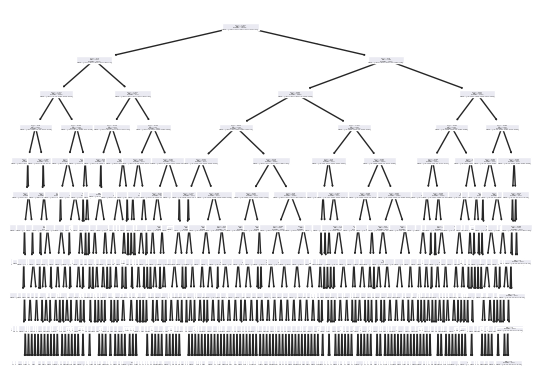

In [22]:
tree.plot_tree(clf, proportion=True)
plt.show()

In [71]:
arr_label.max()

5

In [23]:
cls_backup = clf

In [11]:
import numpy as np
exp = "c"
i = 110
SAVE_DATA_PATH = "/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24"+str(exp)+str(i)

all_exp_dict = np.load("/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24_final_all_exp_dict.npy", allow_pickle='TRUE').item()
# all_exp_dict = np.load(SAVE_DATA_PATH+"all_exp_dict.npy", allow_pickle='TRUE').item()

print(all_exp_dict.keys())
for k in all_exp_dict.keys():
    if k == "Raw_predictions" or k == "Raw_targets":
        print(k, np.shape(all_exp_dict[k]))
        continue
    a_data  = all_exp_dict[k][0]
    l_data = all_exp_dict[k][1]
    print(k, len(a_data), len(l_data))


dict_keys([1000, 'Raw_predictions', 'Raw_targets', 1, 3, 1222, 122, 5, 90, 34, 33])
1000 78 78
Raw_predictions (1, 1000, 1, 4)
Raw_targets (1, 1000, 1)
1 78 78
3 78 78
1222 78 78
122 78 78
5 78 78
90 78 78
34 78 78
33 78 78


In [1]:
!ls /home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/*all_exp_dict*

/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_240all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24110all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24c0all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24c110all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24cc110all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24ccc210all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24cccc190all_exp_dict.npy
/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24_final_all_exp_dict.npy


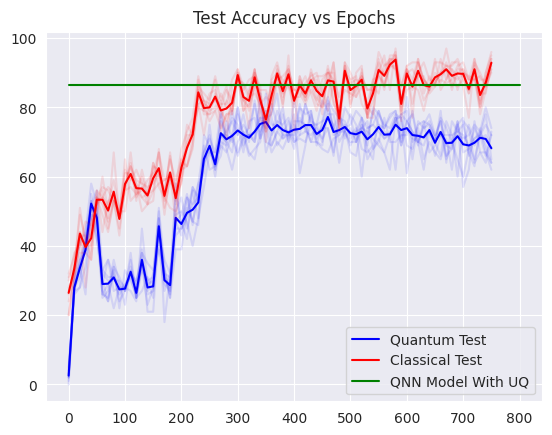

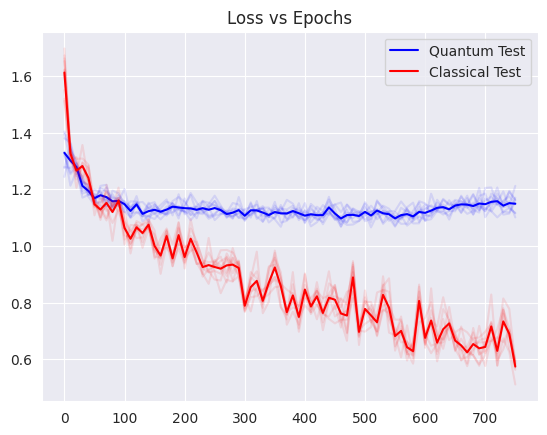

In [33]:
import matplotlib.pyplot as plt


all_exp_dict = np.load("/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24_final_all_exp_dict_100.npy", allow_pickle='TRUE').item()



num_plots = len(all_exp_dict.keys())
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4),
#                         # layout="None"
#                         )

# for n, k in enumerate(all_exp_dict.keys()):
#     if k == "Raw_predictions" or k == "Raw_targets":
#         # print(k, np.shape(all_exp_dict[k]))
#         continue
#     a_data  = all_exp_dict[k][0]
#     l_data = all_exp_dict[k][1]

#     a_data = np.array(a_data)*100
#     print(a_data.sum())
#     row = 0
#     axs[0].plot(a_data)
#     # axs[1].plot(l_data)
# plt.legend([1000,1,3,1222,122,5,90,34,33])
# plt.show()


x_ax =  np.arange(0, 760, 10)
total_data = []
plt.figure("Test Accuracy vs Epochs") # Here's the part I need
plt.title('Test Accuracy vs Epochs')

for n, k in enumerate(all_exp_dict.keys()):
    if k == "Raw_predictions" or k == "Raw_targets":
        # print(k, np.shape(all_exp_dict[k]))
        continue
    a_data  = all_exp_dict[k][0]
    total_data.append(np.array(a_data[:-2]) * 100)
    plt.plot(x_ax, np.array(a_data[:-2]) * 100,   c="blue", label ="_nolegend_" , alpha =0.1 )
# plt.savefig(SAVE_PATH+ "_accuracy_valQ4_"+exp+".png")
# plt.show()
plt.plot(x_ax, np.mean(np.array(total_data) , axis = 0),  c="blue", label ="Quantum Test" , alpha =1)
all_exp_dict = np.load("/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_24_final_all_exp_dict_100.npy", allow_pickle='TRUE').item()
total_data = []
for n, k in enumerate(all_exp_dict.keys()):
    if k == "Raw_predictions" or k == "Raw_targets":
        # print(k, np.shape(all_exp_dict[k]))
        continue
    a_data  = all_exp_dict[k][0]
    total_data.append(np.array(a_data[::3][:-4]) * 100)
    plt.plot(x_ax, np.array(a_data[::3][:-4]) * 100, c="red", label ='_nolegend_', alpha =0.1  )
plt.plot(x_ax, np.mean(np.array(total_data) , axis = 0), c="red", label ="Classical Test", alpha =1 )
plt.plot([0,800],[86.4,86.4] , c="green", label ="With UQ", alpha =1 )
plt.legend([ "Quantum Test", "Classical Test" , "QNN Model With UQ"])
plt.show()


all_exp_dict = np.load("/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/Q_4_24_final_all_exp_dict_100.npy", allow_pickle='TRUE').item()

# x_ax =  np.arange(0, 600, 10)

plt.figure("Loss vs Epochs") # Here's the part I need
plt.title('Loss vs Epochs')
total_data = []
for n, k in enumerate(all_exp_dict.keys()):
    if k == "Raw_predictions" or k == "Raw_targets":
        # print(k, np.shape(all_exp_dict[k]))
        continue
    l_data  = all_exp_dict[k][1]
    total_data.append(l_data[:-2])
    plt.plot(x_ax, l_data[:-2],   c="blue", label ="_nolegend_" , alpha =0.1 )
# plt.savefig(SAVE_PATH+ "_accuracy_valQ4_"+exp+".png")
# plt.show()
plt.plot(x_ax, np.mean(np.array(total_data) , axis = 0),  c="blue", label ="Quantum Test" , alpha =1)
all_exp_dict = np.load("/home/aws_install/projects/QCML/outputs/Binary_Ortho_Classical_Val/CL_4_24_final_all_exp_dict_100.npy", allow_pickle='TRUE').item()


total_data = []
for n, k in enumerate(all_exp_dict.keys()):
    if k == "Raw_predictions" or k == "Raw_targets":
        # print(k, np.shape(all_exp_dict[k]))
        continue
    l_data  = all_exp_dict[k][1]
    total_data.append(l_data[::3][:-4])
    plt.plot(x_ax, l_data[::3][:-4], c="red", label ='_nolegend_', alpha =0.1  )
plt.plot(x_ax, np.mean(np.array(total_data) , axis = 0) , c="red", label ="Classical Test", alpha =1 )
plt.legend([ "Quantum Test", "Classical Test" ])
plt.show()



    